In [1]:
import xarray as xr
import datetime as dt
import os
import pandas as pd
import h5py
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
import sys
import random
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

sys.path.insert(0, '/Users/acheung/TC_RI_P1/scripts/Useful Functions/')

from distance import distance_calculator,pointdist_calc,get_angle
from cylindrical_conversion import interp_to_equal_grid,circle,x_y_grid_to_cylindrical
from scipy import ndimage
from calendar import monthrange
from scipy.interpolate import RegularGridInterpolator
desired_normalized_rad_arr = np.arange(0,6.01,0.01)
matplotlib.rcParams.update({'font.size': 12})
from multiprocessing import Pool

from functools import reduce


In [2]:
def round_to_nearest_half_hour(t):
    if t.minute < 15:
        return t.replace(minute=0, second=0, microsecond=0)
    elif t.minute < 45:
        return t.replace(minute=30, second=0, microsecond=0)
    else:
        if t.hour < 23:
            return (t.replace(hour=t.hour + 1, minute=0, second=0, microsecond=0))
        else:
            days_in_month = monthrange(t.year, t.month)[1]
            if tc_radar_time.day + 1 >  days_in_month:
                return(t.replace(month = t.month+1,day=1, hour=0,
                                             minute=0, second=0,microsecond=0))
            else:
                return(t.replace(day=t.day + 1, hour=0, minute=0, second=0,microsecond=0))

In [3]:
# Settings
imerg_centering = '2-km Center'
height = 2
polar_boolean = True
rotate_setting = 'Tilt-Direction'


In [4]:
nc_file_paths = ['/Users/acheung/data/TC_RADAR/swath/tc_radar_v3l_1997_2019_xy_rel_swath_ships.nc',
                 '/Users/acheung/data/TC_RADAR/swath/tc_radar_v3l_2020_2023_xy_rel_swath_ships.nc']   


tc_radar_data_pre = xr.open_mfdataset(nc_file_paths,combine='nested',concat_dim='num_cases')
tc_radar_data_pre['num_cases'] = range(0,len(tc_radar_data_pre['num_cases']))

# Set initial conditions and filtering
far_from_land_cases =tc_radar_data_pre['dtl_ships'].sel(
    ships_lag_times=0).load().where(
    tc_radar_data_pre['dtl_ships'].sel(ships_lag_times=0).load() >=50).dropna('num_cases')['num_cases']

stype_cases = tc_radar_data_pre['stype_ships'].sel(ships_lag_times=0).load().where((
    tc_radar_data_pre['stype_ships'].sel(ships_lag_times=0).load()== 1) | (
    tc_radar_data_pre['stype_ships'].sel(ships_lag_times=0).load()== 2)).dropna('num_cases')['num_cases']

tilt_mag = tc_radar_data_pre.sel(height=[5,5.5,6,6.5])['tc_tilt_magnitude'].max(
    dim='height').dropna(dim='num_cases')

selected_tilt_level_inds = tc_radar_data_pre.sel(num_cases=tilt_mag['num_cases'],
                      height=[5,5.5,6,6.5])['tc_tilt_magnitude'].argmax(dim='height',keep_attrs=True)

tilt_angs = tc_radar_data_pre.sel(num_cases=tilt_mag['num_cases'],
                      height=[5,5.5,6,6.5])['tc_tilt_direction']*(180/np.pi)

# THIS MIGHT BE WRONG UNITS. CHECK!!!
ohc_inds = tc_radar_data_pre['ohc_ships'].sel(ships_lag_times=0).where(
    tc_radar_data_pre['ohc_ships'].sel(ships_lag_times=0)>=10).dropna('num_cases')['num_cases'].values

rh_inds = tc_radar_data_pre['rhmd_ships'].sel(ships_lag_times=0).where(
    tc_radar_data_pre['rhmd_ships'].sel(ships_lag_times=0) >= 40).dropna('num_cases')['num_cases'].values

# Snip TC-RADAR Dataset to times wit IMERG data (1998 and later)
year_inds = tc_radar_data_pre['swath_year'].where(tc_radar_data_pre['swath_year'] >=1998).dropna('num_cases')['num_cases'].values

list_of_lists = [stype_cases.values,far_from_land_cases.values,tilt_mag['num_cases'].values,ohc_inds,rh_inds,year_inds]
# list_of_lists = [far_from_land_cases.values,tilt_mag['num_cases'].values]

result = list(reduce(lambda a, b: set(a) & set(b), list_of_lists))

filtered_tc_radar = tc_radar_data_pre.sel(num_cases=result)

data_selection = 'recentered_reflectivity'

if (data_selection == 'recentered_reflectivity'):
    corrected_data = xr.open_dataset('/Users/acheung/data/TC_RADAR/swath/tc_radar_v3l_corrected_ref.nc')
    corrected_data = corrected_data.assign(num_cases=corrected_data["num_cases"])
    filtered_data = corrected_data['recentered_corrected_reflectivity'].sel(num_cases=result,height=2)
else:
    filtered_data = filtered_tc_radar.sel(height=2)[data_selection]

rotate_setting = 'Tilt-Direction'


In [5]:
tc_radar_data = filtered_tc_radar

# Identify all storm names and times to find IMERG data closest to TC RADAR Merged Time
years,months,days,hours,minutes = tc_radar_data['swath_year'].values,\
    tc_radar_data['swath_month'].values,tc_radar_data['swath_day'].values,\
    tc_radar_data['swath_hour'].values,tc_radar_data['swath_min'].values                

# Find file paths and download any files not in directory

timedeltas = [-60,-30,0,30] # zero is 0 to 30 minutes and thirty is 30 mins to 1 h
# timedeltas = [0] # zero is 0 to 30 minutes and thirty is 30 mins to 1 h

filepaths = []
rounded_time_list = []
for i in range(len(tc_radar_data['num_cases'])):
    curr_time_filepaths = []
    for times in timedeltas:
        tc_radar_time = dt.datetime(years[i],months[i],days[i],hours[i],minutes[i])
        rounded_time = round_to_nearest_half_hour(tc_radar_time)
        time_desired = rounded_time + dt.timedelta(minutes=times)
        # print(i,tc_radar_time,rounded_time)

        year = time_desired.year
        day_of_year = time_desired.strftime('%j')
        day_stripped = time_desired.strftime('%Y%m%d')
        time_stripped = time_desired.strftime('%H%M%S')
        min_of_day = str(time_desired.hour*60 + time_desired.minute).zfill(4)
        end_time_stripped = (time_desired+dt.timedelta(minutes=29,seconds=59)).strftime('%H%M%S')

        # If IMERG file does not exist, download it
        IMERG_file_path = '/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year+'/'+\
            '3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+'-E'+end_time_stripped+\
            '.'+min_of_day+'.V07B.HDF5'
        curr_time_filepaths.append(IMERG_file_path)
        # print(IMERG_file_path)
        # print(os.path.exists(IMERG_file_path))

            # If day directory does not exist, make day directory
        if os.path.exists('/Users/acheung/data/IMERG/'+str(year)) == False:
            os.mkdir('/Users/acheung/data/IMERG/'+str(year))

        if os.path.exists('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year) == False:
            os.mkdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

        if os.path.exists(IMERG_file_path) == False:
            url_desired = "https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/"\
                +str(year)+'/'+day_of_year+'/'+'3B-HHR.MS.MRG.3IMERG.'+day_stripped+'-S'+time_stripped+\
                '-E'+end_time_stripped+'.'+min_of_day+'.V07B.HDF5'
            os.chdir('/Users/acheung/data/IMERG/'+str(year)+'/'+day_of_year)

            os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                      + url_desired)
    filepaths.append(curr_time_filepaths)
    rounded_time_list.append(rounded_time)

all_time_filepaths = pd.DataFrame(filepaths)
all_time_filepaths.index = tc_radar_data['num_cases'].astype(int)

time_list_pd = pd.DataFrame(rounded_time_list)
time_list_pd.index = tc_radar_data['num_cases'].astype(int)


In [6]:
centering_lat = tc_radar_data['tc_center_latitudes'].sel(height=height).values
centering_lon = tc_radar_data['tc_center_longitudes'].sel(height=height).values

tilt_mag = (tc_radar_data.sel(height=[5,5.5,6,6.5])[
    'tc_tilt_magnitude'])


In [7]:
# case_loop_list = []
# all_overpass_data = []

def process_imerg_image(case_loop):

    precip_list = []
    for now_it in range(len(all_time_filepaths.loc[case_loop])):
        fn = all_time_filepaths.loc[case_loop][now_it]
        try:
            f = h5py.File(fn, 'r')
        except: # If the file is corrupt, remove and re-download
            os.system('rm ' + fn)
            os.chdir(fn[0:35])
            new_url = 'https://gpm1.gesdisc.eosdis.nasa.gov/data/GPM_L3/GPM_3IMERGHH.07/' + fn[26:]
            os.system('wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --keep-session-cookies '
                      + new_url)
            f = h5py.File(fn, 'r')
        # Work on precip file
        groups = [ x for x in f.keys() ]
        # print(groups)
        gridMembers = [ x for x in f['Grid'] ]
        # print(gridMembers)

        # Get the precipitation, latitude, and longitude variables
        precip = f['Grid/precipitation'][0][:][:]
        precip = np.transpose(precip)
        precip[precip<-999]=np.nan

        theLats = f['Grid/lat'][:]
        theLons = f['Grid/lon'][:]
        x, y = np.float32(np.meshgrid(theLons, theLats))

        precip_list.append(precip)
        
        # Compile a plot of microwave overpass map at time desired

        if now_it == int(np.ceil(np.median(range(len(all_time_filepaths.loc[case_loop]))))):
            MW_Overpass_Time = f['Grid//Intermediate/MWobservationTime'][0][:][:]
            MW_Overpass_Time = np.where(MW_Overpass_Time==-9999, np.nan, MW_Overpass_Time).transpose()

    # For now, we take a mean. Might need a different filter in the future
    precip_mean = np.mean(np.asarray(precip_list),axis=0)

    # Find interpolated storm-center
    # Get Storm Name and time
    storm_name = str(tc_radar_data['storm_name'].sel(num_cases=case_loop).values)

    # Overall Subplot Title
    bt_vmax = tc_radar_data['vmax_ships'].sel(num_cases=case_loop).sel(ships_lag_times=0).values
    bt_intensity_arr = tc_radar_data['vmax_ships'].sel(num_cases=case_loop).values

#         if sorting_type == 'tilt': # We only do weak storms for tilt sorting
#             if float(bt_vmax) > 65: # Only record weak storm cases
#                 print('Skipped '+ str(case_loop) + ' due to strong storm of ' + str(bt_vmax) + ' kt')
#                 continue

    nearest_30_min_ts = time_list_pd.loc[case_loop][0].timestamp()
    bt_times = tc_radar_data.sel(num_cases=case_loop)['ships_lag_times'].where(tc_radar_data.sel(num_cases=case_loop)['lat_ships'].notnull()).dropna('ships_lag_times').values
    bt_lats = tc_radar_data.sel(num_cases=case_loop)['lat_ships'].dropna('ships_lag_times').values
    bt_lons = tc_radar_data.sel(num_cases=case_loop)['lon_ships'].dropna('ships_lag_times').values * -1

    year_now,month,day,hour,minute = tc_radar_data['swath_year'].sel(num_cases=case_loop).values,\
        tc_radar_data['swath_month'].sel(num_cases=case_loop).values,tc_radar_data['swath_day'].sel(num_cases=case_loop).values,\
        tc_radar_data['swath_hour'].sel(num_cases=case_loop).values,tc_radar_data['swath_min'].sel(num_cases=case_loop).values

    radar_time = dt.datetime(year_now,month,day,hour,minute)
    nearest_syn_ts = pd.DataFrame([radar_time])[0].dt.round("6h")[0].timestamp()

    time_secs_arr = nearest_syn_ts + (bt_times * 3600)

    # Don't plot best-track (SHIPS) center if there is no information
    if imerg_centering == '2-km Center':
        centering_lat = tc_radar_data['tc_center_latitudes'].sel(num_cases=case_loop,height=height).values
        centering_lon = tc_radar_data['tc_center_longitudes'].sel(num_cases=case_loop,height=height).values
        # For cases that use 2-km centering, we need a center here to exist, duhh
    elif imerg_centering == 'best-track':
        if len(bt_lats) > 0:
            latspl = UnivariateSpline(time_secs_arr,bt_lats,k=2,s=0)
            centering_lat = latspl(nearest_30_min_ts)
        if len(bt_lons) > 0:
            lonspl = UnivariateSpline(time_secs_arr,bt_lons,k=2,s=0)
            centering_lon = lonspl(nearest_30_min_ts)

    # Find index closest to interpolated best-track center or 2-km radar center
    distance_arr = distance_calculator(x, y,(centering_lon,centering_lat))

    abs_dist_arr = (abs(distance_arr))

    min_dist_ind = np.where(abs_dist_arr == np.nanmin(abs_dist_arr))

    # Find tilt magnitude and tilt direction from TC-RADAR

    '''
    Find the tilt magnitude and tilt direction (mat angle). We take the highest 
    tilt height available between 5 and 6.5 km
    '''
    tilt_mag_now = (tc_radar_data.sel(num_cases=case_loop,height=[5,5.5,6,6.5])[
    'tc_tilt_magnitude'].dropna(dim='height'))
    tilt_mag_use = np.nanmax(tilt_mag_now.values)
    
    if rotate_setting == 'Tilt-Direction':
        angle_rotate = (tc_radar_data.sel(num_cases=case_loop,height=[5,5.5,6,6.5])[
            'tc_tilt_direction'].dropna(dim='height').values* (180/np.pi))[np.nanargmax(tilt_mag_now.values)] # This is a math angle!!!
    elif rotate_setting == 'Shear-Direction':
        angle_rotate = 90 - float(tc_radar_data['shtd_ships'].sel(num_cases=case_loop,ships_lag_times=0))

    # Find distance and angle of 6km-level center

    mid_lon = tc_radar_data['tc_center_longitudes'].sel(num_cases=case_loop,height=[5,5.5,6,6.5]).values[np.nanargmax(tilt_mag_now.values)]
    mid_lat = tc_radar_data['tc_center_latitudes'].sel(num_cases=case_loop,height=[5,5.5,6,6.5]).values[np.nanargmax(tilt_mag_now.values)]

    dist_to_mid_center = pointdist_calc(mid_lat,mid_lon,centering_lat,centering_lon)

    # This is NOT a perfect estimate of the angle, given the Earth's curvature

    angle_to_mlc = get_angle(centering_lon,centering_lat,mid_lon,mid_lat) # degrees from math angle zero, or east

    # Slice arrays to within 100 indices of interpolated best-track center

    sliced_lon_grid = x[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]

    sliced_lat_grid = y[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]

    sliced_precip = precip_mean[min_dist_ind[0][0]-100:min_dist_ind[0][0]+100,min_dist_ind[1][0]-100:min_dist_ind[1][0]+100]

    # Sliced Overpass Time Data
    sliced_lon_mw_grid = x[min_dist_ind[0][0]-300:min_dist_ind[0][0]+300,min_dist_ind[1][0]-300:min_dist_ind[1][0]+300]
    sliced_lat_mw_grid = y[min_dist_ind[0][0]-300:min_dist_ind[0][0]+300,min_dist_ind[1][0]-300:min_dist_ind[1][0]+300]
    sliced_mw_overpass_time = MW_Overpass_Time[min_dist_ind[0][0]-300:min_dist_ind[0][0]+300,min_dist_ind[1][0]-300:min_dist_ind[1][0]+300]
    current_overpass_data = [centering_lon,centering_lat,sliced_lon_mw_grid,sliced_lat_mw_grid,sliced_mw_overpass_time]
    # all_overpass_data.append(current_overpass_data)
    
    # NEVER FORGET TO MULTIPLY RADIUS ARRAYS BY DX FOR IMERG PLOTS!!!

    dx = 2
    dy = 2

    # Interpolate IMERG data to equal-distance grid

    eq_lon_grid,eq_lat_grid,eq_dist_data = interp_to_equal_grid(sliced_lon_grid,sliced_lat_grid,
                                                            sliced_precip,dx = dx,dy=dy)


    distance_arr_sliced = distance_calculator(eq_lon_grid, eq_lat_grid,(centering_lon,centering_lat))

    abs_dist_arr_sliced = (abs(distance_arr_sliced))

    min_dist_ind_sliced = np.where(abs_dist_arr_sliced == np.nanmin(abs_dist_arr_sliced))

    pts_above = eq_dist_data.shape[0] - min_dist_ind_sliced[0][0]
    y_range = np.arange(-min_dist_ind_sliced[0][0],pts_above) * dy

    pts_right = eq_dist_data.shape[1] - min_dist_ind_sliced[1][0]
    x_range = np.arange(-min_dist_ind_sliced[1][0],pts_right) * dx

    xv, yv = np.meshgrid(x_range, y_range)

    x_range.shape[0],np.where(x_range==0)[0][0]

    x_zero_loc = np.where(x_range==0)[0][0]

    if x_zero_loc > x_range.shape[0]/2:
        x_offset = int(x_range.shape[0]-x_zero_loc)
    elif x_zero_loc <= x_range.shape[0]/2:
        x_offset = x_zero_loc

    y_zero_loc = np.where(y_range==0)[0][0]

    if y_zero_loc > y_range.shape[0]/2:
        y_offset = int(y_range.shape[0]-y_zero_loc)
    elif y_zero_loc <= y_range.shape[0]/2:
        y_offset = y_zero_loc

    x_even_inds = x_range[x_zero_loc-(x_offset-1):x_zero_loc+x_offset+1]
    y_even_inds = y_range[y_zero_loc-(y_offset-1):y_zero_loc+y_offset+1]

    sliced_eq_data_pd = pd.DataFrame(eq_dist_data,columns=x_range,index=y_range)

    evenly_sliced_pd = sliced_eq_data_pd[x_even_inds].loc[y_even_inds]

    x_evenly_sliced, y_evenly_sliced = np.meshgrid(x_even_inds, y_even_inds)
    
    img_rotate = ndimage.rotate(evenly_sliced_pd, angle_rotate, reshape=False,cval=np.nan,prefilter=False)
    img_rotate_pd = pd.DataFrame(img_rotate,columns=evenly_sliced_pd.columns,index=evenly_sliced_pd.index)

    pd_last_slice = img_rotate_pd[np.arange(-150,150.1,2)].loc[-150:150]
    x_evenly_last_sliced, y_evenly_last_sliced = np.meshgrid(pd_last_slice.columns, pd_last_slice.index)

    # Find location of MLC on tilt-relative grid

    mlc_rotated_angle = angle_to_mlc - angle_rotate

    mlc_x = dist_to_mid_center * np.cos(mlc_rotated_angle*(np.pi/180))
    mlc_y = dist_to_mid_center * np.sin(mlc_rotated_angle*(np.pi/180))

    rmw_now = tc_radar_data['tc_rmw'].sel(num_cases=case_loop,height=height).values
    shear_now = tc_radar_data['shrd_ships'].sel(num_cases=case_loop).sel(ships_lag_times=0).values
    dtl_now = tc_radar_data['dtl_ships'].sel(num_cases=case_loop,ships_lag_times=0).values
    ohc_now = tc_radar_data['ohc_ships'].sel(num_cases=case_loop,ships_lag_times=0).values
    rhmd_now = tc_radar_data['rhmd_ships'].sel(num_cases=case_loop,ships_lag_times=0).values
    
    full_info_arr = [storm_name,time_list_pd.loc[case_loop][0],tilt_mag_use,bt_vmax,rmw_now,shear_now,dtl_now,
                     ohc_now,rhmd_now,mlc_x,mlc_y]

    if polar_boolean == True:
        cylindrical_data, THETA, rad_arr = x_y_grid_to_cylindrical(
            center_inds=[0,0],radius_min=0,radius_max=500,radius_interval=1, NOP=1000,
            x_grid=img_rotate_pd.index.values,y_grid=img_rotate_pd.columns.values,
            data=img_rotate_pd.values)

        # Interpolate data to normalized RMW spacings
        normalized_rad_arr = rad_arr/rmw_now

        polar_interp = RegularGridInterpolator((normalized_rad_arr,THETA), cylindrical_data,bounds_error=False)

        theta_mesh,desired_rad_mesh = np.meshgrid(THETA,desired_normalized_rad_arr)
        polar_rad_norm_data = polar_interp((desired_rad_mesh,THETA))            

    return current_overpass_data, pd_last_slice, full_info_arr, bt_intensity_arr, polar_rad_norm_data, THETA,case_loop


In [13]:
# all_overpass_data = []
# all_last_slices = []
# full_info_arr_list = []
# vmax_arr_list = []
# cylindrical_normalized_list = []
# THETA_list = []
# case_loop_list = []

# count = 0
# for i in tc_radar_data['num_cases'].values:
#     current_overpass_data, pd_last_slice, full_info_arr, bt_intensity_arr, polar_rad_norm_data, THETA,case_loop = process_imerg_image(i)
#     all_overpass_data.append(current_overpass_data)
#     all_last_slices.append(pd_last_slice)
#     full_info_arr_list.append(full_info_arr)
#     vmax_arr_list.append(bt_intensity_arr)
#     cylindrical_normalized_list.append(polar_rad_norm_data)
#     if i == tc_radar_data['num_cases'].values[0]:
#         THETA_list.append(THETA)
#     case_loop_list.append(case_loop)
#     count = count + 1
#     print(count,len(tc_radar_data['num_cases'].values))

# THETA = THETA_list

# full_info_col_names = ['Storm Name','Time','Tilt Magnitude','Intensity',
#                        'RMW','Deep-Layer Shear','DTL','OHC','RHMD','MLC X','MLC Y']

# finalx,finaly = np.meshgrid(all_last_slices[0].columns,all_last_slices[0].index)

# # NEED TO FIX DATAFRAME INDEX HERE!!! 

# full_info_pd = pd.DataFrame(full_info_arr_list,columns=full_info_col_names,index=case_loop_list)
# vmax_arr_pd = pd.DataFrame(vmax_arr_list,columns=tc_radar_data['vmax_ships']['ships_lag_times'].values,
#                           index=case_loop_list)


# all_last_slices_xr = xr.DataArray(all_last_slices,dims=["case","x", "y"],coords=dict(
#         x=(["x", "y"], finalx),
#         y=(["x", "y"], finaly),
#         case=(case_loop_list)
#     ))

# all_last_slices_xr.to_netcdf('/Users/acheung/data/Composite_Data/imerg_composites.nc')


# theta_mesh,desired_rad_mesh = np.meshgrid(THETA,desired_normalized_rad_arr)

# all_cylindrical_xr = xr.DataArray(cylindrical_normalized_list,dims=["case","radius", "azimuth"],coords=dict(
#         azimuth=(["radius", "azimuth"], theta_mesh),
#         radius=(["radius", "azimuth"], desired_rad_mesh),
#                case=(case_loop_list)
#     ))

# all_cylindrical_xr.to_netcdf('/Users/acheung/data/Composite_Data/cylindrical_composite.nc')
# full_info_pd.to_csv('/Users/acheung/data/Composite_Data/Composite_info.csv')
# vmax_arr_pd.to_csv('/Users/acheung/data/Composite_Data/vmax_arr_arrs.csv')

# import pickle
# os.chdir('/Users/acheung/data/Composite_Data/')
# with open('overpass.pkl', 'wb') as f:
#     pickle.dump(all_overpass_data, f)

In [8]:
# Open Saved Data
import pickle
os.chdir('/Users/acheung/data/Composite_Data/')
with open('overpass.pkl', 'rb') as f:
    all_overpass_data = pickle.load(f)

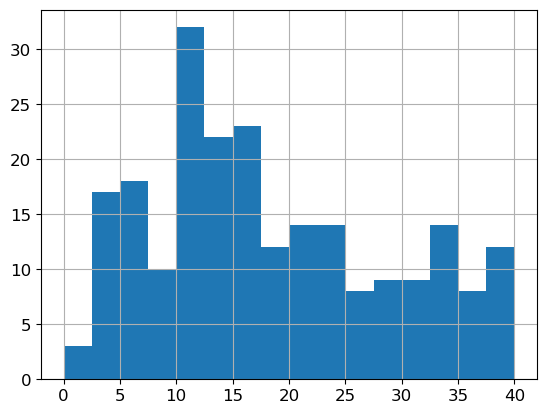

In [9]:
storm_intensity_filter = 'Weak Only'

vmax_arr_pd = pd.read_csv('/Users/acheung/data/Composite_Data/vmax_arr_arrs.csv',index_col=0)
vmax_arr_pd.columns = vmax_arr_pd.columns.astype(float)
full_info_pd = pd.read_csv('/Users/acheung/data/Composite_Data/Composite_info.csv',index_col=0)
all_last_slices_xr = xr.open_dataset('/Users/acheung/data/Composite_Data/imerg_composites.nc')
all_last_slices_xr = all_last_slices_xr['__xarray_dataarray_variable__']

all_cylindrical_xr = xr.open_dataset('/Users/acheung/data/Composite_Data/cylindrical_composite.nc')
all_cylindrical_xr = all_cylindrical_xr['__xarray_dataarray_variable__']

overpass_pd = pd.DataFrame(all_overpass_data,columns=['Lon','Lat','Lon-Array','Lat-Array','Overpass Times'])
overpass_pd.index = all_last_slices_xr['case']

all_last_slices_xr = all_last_slices_xr.sel(case = full_info_pd.index)

all_cylindrical_xr = all_cylindrical_xr.sel(case = full_info_pd.index)

# Sort by Tilt Variables (for weak cases)

weak_storms_info_pd = full_info_pd.loc[full_info_pd['Intensity'].where(full_info_pd['Intensity'] <= 65).dropna().index] # kt (threshold for weak storms)
strong_storms_info_pd = full_info_pd.loc[full_info_pd['Intensity'].where(full_info_pd['Intensity'] > 65).dropna().index] # kt (threshold for weak storms)


if storm_intensity_filter == 'Weak Only':
    small_tilt_indices = weak_storms_info_pd['Tilt Magnitude'].where(weak_storms_info_pd['Tilt Magnitude'] < 40).dropna().index
    large_tilt_indices = weak_storms_info_pd['Tilt Magnitude'].where(weak_storms_info_pd['Tilt Magnitude'] >= 40).dropna().index    
elif storm_intensity_filter == 'Strong Only':
    small_tilt_indices = strong_storms_info_pd['Tilt Magnitude'].where(strong_storms_info_pd['Tilt Magnitude'] < 40).dropna().index
    large_tilt_indices = strong_storms_info_pd['Tilt Magnitude'].where(strong_storms_info_pd['Tilt Magnitude'] >= 40).dropna().index 
    
small_tilt_cases = all_last_slices_xr.sel(case = small_tilt_indices)
small_tilt_rmws = full_info_pd.loc[small_tilt_indices]['RMW']
small_tilt_mlcs_x = full_info_pd.loc[small_tilt_indices]['MLC X']
small_tilt_mlcs_y = full_info_pd.loc[small_tilt_indices]['MLC Y']
large_tilt_cases = all_last_slices_xr.sel(case = large_tilt_indices)
large_tilt_rmws = full_info_pd.loc[large_tilt_indices]['RMW']
large_tilt_mlcs_x = full_info_pd.loc[large_tilt_indices]['MLC X']
large_tilt_mlcs_y = full_info_pd.loc[large_tilt_indices]['MLC Y']

# Sort by tilt bins (for strong cases)

# Sort by Intensity Variables
weak_indices = full_info_pd['Intensity'].where(full_info_pd['Intensity'] <=65).dropna().index
strong_indices = full_info_pd['Intensity'].where(full_info_pd['Intensity'] > 65).dropna().index
weak_cases_imerg = all_last_slices_xr.sel(case = weak_indices)
strong_cases_imerg = all_last_slices_xr.sel(case = strong_indices)
weak_cases_rmw = full_info_pd.loc[weak_indices]['RMW']
strong_cases_rmw = full_info_pd.loc[strong_indices]['RMW']
weak_cases_mlcs_x = full_info_pd.loc[weak_indices]['MLC X']
weak_cases_mlcs_y = full_info_pd.loc[weak_indices]['MLC Y']
strong_cases_mlcs_x = full_info_pd.loc[strong_indices]['MLC X']
strong_cases_mlcs_y = full_info_pd.loc[strong_indices]['MLC Y']

# Sort by Intensity Change

future_time = 12
future_change = vmax_arr_pd[future_time]-vmax_arr_pd[0]

# Toggle Storm Intensity Filtering (only affects intensity change cases)

if storm_intensity_filter == 'Weak Only':
    future_change = future_change[weak_indices]
elif storm_intensity_filter == 'Strong Only':
    future_change = future_change[strong_indices]
    
# Toggle Shear Filtering (only affects intensity change plotting)

shear_criteria = 'none'

if shear_criteria == 'none':
    RI_cases = future_change.where(future_change >= 20).dropna()
    Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20)).dropna()
    SS_cases = future_change.where((future_change >= -5) & (future_change <= 5)).dropna()
    Weakening_cases = future_change.where(future_change < -5).dropna()
if shear_criteria == 'weak':
    RI_cases = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] < 10)).dropna()
    Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20) &
                               (full_info_pd['Deep-Layer Shear'] < 10)).dropna()
    
    SS_cases = future_change.where((future_change >= -5) & (future_change <= 5) &
                               (full_info_pd['Deep-Layer Shear'] < 10)).dropna()
    
    Weakening_cases = future_change.where((future_change < -5) &
                               (full_info_pd['Deep-Layer Shear'] < 10)).dropna() 
if shear_criteria == 'moderate':
    RI_cases = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)& 
                               (full_info_pd['Deep-Layer Shear'] < 20)).dropna()
    Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)& 
                               (full_info_pd['Deep-Layer Shear'] < 20)).dropna()
    
    SS_cases = future_change.where((future_change >= -5) & (future_change <= 5) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)& 
                               (full_info_pd['Deep-Layer Shear'] < 20)).dropna()
    
    Weakening_cases = future_change.where((future_change < -5) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)& 
                               (full_info_pd['Deep-Layer Shear'] < 20)).dropna()

if shear_criteria == 'moderate or stronger':
    RI_cases = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)).dropna()
    Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)).dropna()
    
    SS_cases = future_change.where((future_change >= -5) & (future_change <= 5) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)).dropna()
    
    Weakening_cases = future_change.where((future_change < -5) &
                               (full_info_pd['Deep-Layer Shear'] >= 10)).dropna()
    
if shear_criteria == 'strong':
    RI_cases = future_change.where((future_change >= 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 20)).dropna()
    Intensifying_cases = future_change.where((future_change > 5) & (future_change < 20) &
                               (full_info_pd['Deep-Layer Shear'] >= 20)).dropna()
    
    SS_cases = future_change.where((future_change >= -5) & (future_change <= 5) &
                               (full_info_pd['Deep-Layer Shear'] >= 20)).dropna()
    
    Weakening_cases = future_change.where((future_change < -5) &
                               (full_info_pd['Deep-Layer Shear'] >= 20)).dropna()

RI_imerg_data = all_last_slices_xr.sel(case = RI_cases.index)
intensifying_imerg_data = all_last_slices_xr.sel(case = Intensifying_cases.index)
SS_imerg_data = all_last_slices_xr.sel(case = SS_cases.index)
weakening_imerg_data = all_last_slices_xr.sel(case = Weakening_cases.index)

RI_rmw = full_info_pd.loc[RI_cases.index]['RMW']
intensifying_rmw = full_info_pd.loc[Intensifying_cases.index]['RMW']
SS_rmw = full_info_pd.loc[SS_cases.index]['RMW']
Weakening_rmw = full_info_pd.loc[Weakening_cases.index]['RMW']

weakening_cases_mlcs_x = full_info_pd.loc[Weakening_cases.index]['MLC X']
weakening_cases_mlcs_y = full_info_pd.loc[Weakening_cases.index]['MLC Y']

intensifying_cases_mlcs_x = full_info_pd.loc[Intensifying_cases.index]['MLC X']
intensifying_cases_mlcs_y = full_info_pd.loc[Intensifying_cases.index]['MLC Y']

SS_cases_mlcs_x = full_info_pd.loc[SS_cases.index]['MLC X']
SS_cases_mlcs_y = full_info_pd.loc[SS_cases.index]['MLC Y']

RI_cases_mlcs_x = full_info_pd.loc[RI_cases.index]['MLC X']
RI_cases_mlcs_y = full_info_pd.loc[RI_cases.index]['MLC Y']

# Organize strong cases by tilt magnitude bins
strong_storm_tilts = full_info_pd.loc[strong_indices]['Tilt Magnitude']
weak_storm_tilts = full_info_pd.loc[weak_indices]['Tilt Magnitude']

plt.hist(weak_storm_tilts,bins=np.arange(0,40.1,2.5))
plt.grid()

tilt_bin_setting = 'weak'

if tilt_bin_setting == 'weak':

    tilt_bin_edges = [8,16,24,32,40,56,72,int(np.ceil(weak_storm_tilts.max()))]

    bin_list = [] # Put each storm's tilts into bins, including the index, which will be used later

    for bin_i in range(len(tilt_bin_edges)):
        if bin_i == 0:
            bin_edge_now_tilt = weak_storm_tilts.where(weak_storm_tilts < tilt_bin_edges[bin_i]).dropna()
        else:
            bin_edge_now_tilt = weak_storm_tilts.where((weak_storm_tilts < tilt_bin_edges[bin_i]
                                     ) & (weak_storm_tilts >= tilt_bin_edges[bin_i-1])).dropna()

        bin_list.append(bin_edge_now_tilt)
        
elif tilt_bin_setting == 'strong':

    tilt_bin_edges = [4,8,12,16,20,24,28,int(np.ceil(strong_storm_tilts.max()))]

    bin_list = [] # Put each storm's tilts into bins, including the index, which will be used later

    for bin_i in range(len(tilt_bin_edges)):
        if bin_i == 0:
            bin_edge_now_tilt = strong_storm_tilts.where(strong_storm_tilts < tilt_bin_edges[bin_i]).dropna()
        else:
            bin_edge_now_tilt = strong_storm_tilts.where((strong_storm_tilts < tilt_bin_edges[bin_i]
                                     ) & (strong_storm_tilts >= tilt_bin_edges[bin_i-1])).dropna()

        bin_list.append(bin_edge_now_tilt)

In [10]:
RI_stats = np.mean(full_info_pd.loc[RI_cases.index][['Tilt Magnitude','Intensity',
                                                     'RMW','Deep-Layer Shear','DTL',
                                                     'MLC X','MLC Y']],axis=0)
Intensifying_stats = np.mean(full_info_pd.loc[Intensifying_cases.index][['Tilt Magnitude',
                                                                         'Intensity','RMW',
                                                                         'Deep-Layer Shear',
                                                                         'DTL','MLC X','MLC Y']],axis=0)
SS_stats = np.mean(full_info_pd.loc[SS_cases.index][['Tilt Magnitude',
                                                     'Intensity','RMW',
                                                     'Deep-Layer Shear',
                                                     'DTL','MLC X','MLC Y']],axis=0)
Weakening_stats = np.mean(full_info_pd.loc[Weakening_cases.index][['Tilt Magnitude',
                                                                   'Intensity','RMW',
                                                                   'Deep-Layer Shear',
                                                                   'DTL','MLC X','MLC Y']],axis=0)


strong_case_stats = np.mean(full_info_pd.loc[strong_indices][['Tilt Magnitude',
                                                              'Intensity','RMW',
                                                              'Deep-Layer Shear',
                                                              'DTL','MLC X','MLC Y']],axis=0)
weak_case_stats = np.mean(full_info_pd.loc[weak_indices][['Tilt Magnitude',
                                                          'Intensity','RMW',
                                                          'Deep-Layer Shear',
                                                          'DTL','MLC X','MLC Y']],axis=0)

# print(RI_stats,Intensifying_stats,SS_stats,Weakening_stats)

pd.DataFrame(Weakening_stats,columns=['Weakening']).transpose()
# pd.DataFrame(SS_stats,columns=['Steady-State']).transpose()
# pd.DataFrame(Intensifying_stats,columns=['Slowly Intensifying']).transpose()
# pd.DataFrame(RI_stats,columns=['RI']).transpose()

,Tilt Magnitude,Intensity,RMW,Deep-Layer Shear,DTL,MLC X,MLC Y
Weakening,18.029529,65.0,53.090909,19.518182,223.363636,18.043492,0.006403


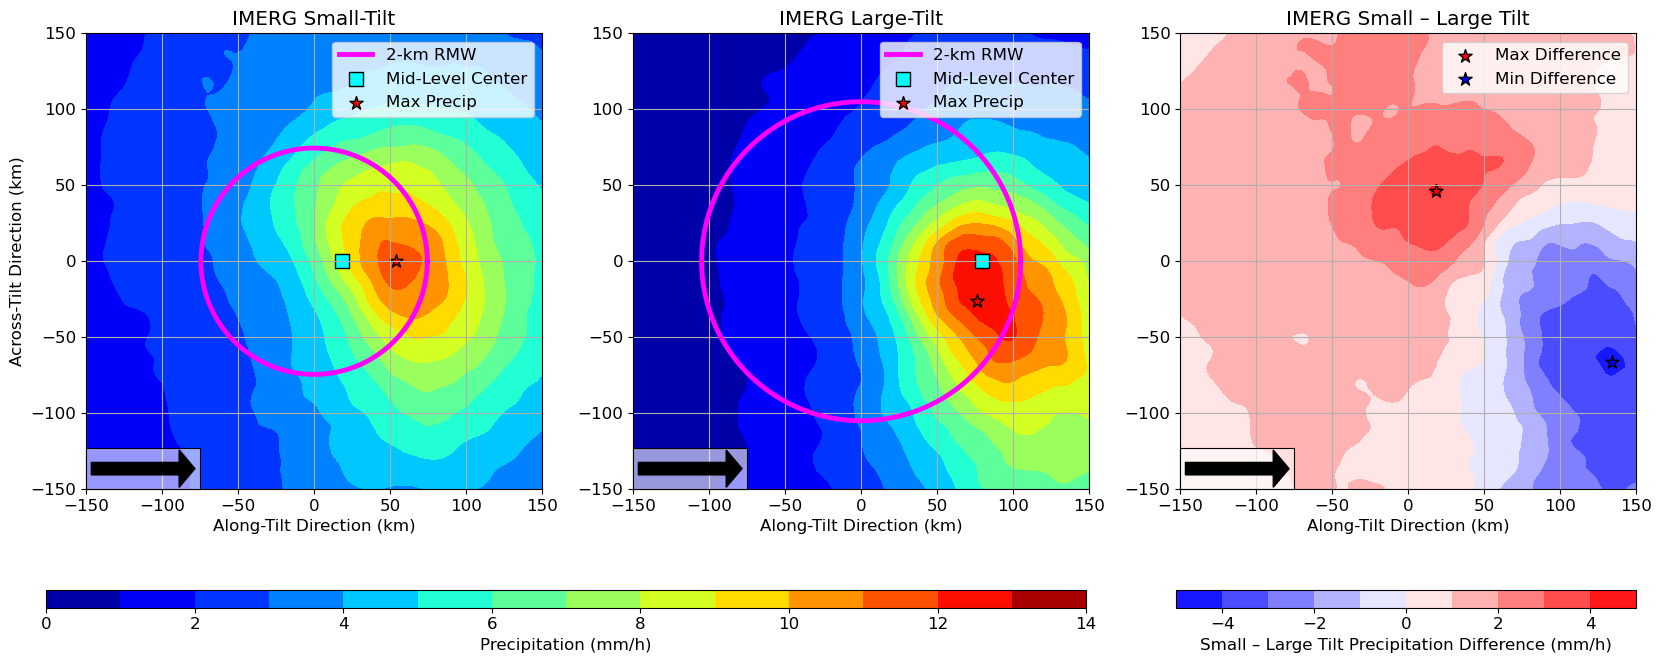

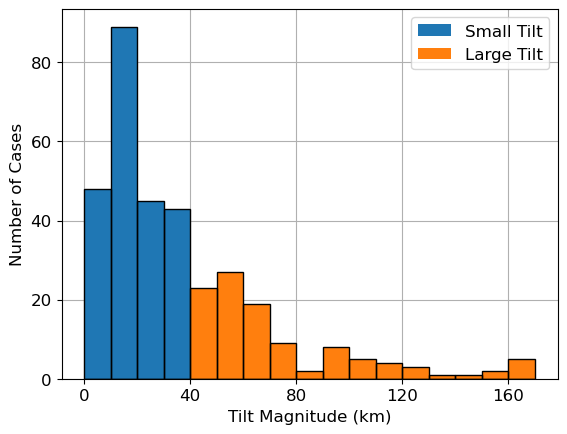

In [11]:
# Plot composites by tilt

large_tilt_mean = large_tilt_cases.mean('case')
small_tilt_mean = small_tilt_cases.mean('case')

large_tilt_Z = 300*(large_tilt_mean **(1.35))
large_tilt_dBZ = 10*np.log10(large_tilt_Z)

small_tilt_Z = 300*(small_tilt_mean **(1.35))
small_tilt_dBZ = 10*np.log10(small_tilt_Z)


# Identify mean MLC X and Y

mean_large_tilt_mlc_x = large_tilt_mlcs_x.mean()
mean_large_tilt_mlc_y = large_tilt_mlcs_y.mean()
mean_small_tilt_mlc_x = small_tilt_mlcs_x.mean()
mean_small_tilt_mlc_y = small_tilt_mlcs_y.mean()

mode = 'Precip'

fig = plt.figure(figsize=(20, 7)) 

gs = fig.add_gridspec(1,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)

# Draw Circle

X,Y,THETA = circle([0,0],small_tilt_rmws.mean(),1000)

if mode == 'dBZ':
    weak_cf = ax.contourf(small_tilt_dBZ['x'], small_tilt_dBZ['y'],small_tilt_dBZ,np.arange(18,42.1,2))
#     weak_cf = ax.pcolormesh(x_evenly_last_sliced, y_evenly_last_sliced,small_tilt_dBZ)
    plt.colorbar(weak_cf,label='Reflectivity (dBZ)')
    ax.grid()
    ax.set_title('IMERG Small-Tilt')
    ax.set_xlabel('Along-Tilt Direction (km)')
    ax.set_ylabel('Across-Tilt Direction (km)')
    ax.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax.scatter(mean_small_tilt_mlc_x,mean_small_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',
               color='cyan',marker='s',label='Mid-Level Center')
    ind_1_max_small_dBZ_tilt = small_tilt_dBZ.argmax(dim=["x","y"])['x'].values
    ind_2_max_small_dBZ_tilt = small_tilt_dBZ.argmax(dim=["x","y"])['y'].values
    actual_x_small_dBZ_tilt = small_tilt_dBZ[ind_1_max_small_dBZ_tilt,ind_2_max_small_dBZ_tilt]['x']
    actual_y_small_dBZ_tilt = small_tilt_dBZ[ind_1_max_small_dBZ_tilt,ind_2_max_small_dBZ_tilt]['y']
    ax.scatter(actual_x_small_dBZ_tilt,actual_y_small_dBZ_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max dBZ')
    ax.legend(loc=1)
elif mode == 'Precip':
    weak_cf = ax.contourf(small_tilt_mean['x'], small_tilt_mean['y'],small_tilt_mean,levels=np.arange(0,14.1,1),cmap='jet')
    cax_1 = plt.axes([0.105, 0, 0.52, 0.025])
    plt.colorbar(weak_cf,label='Precipitation (mm/h)',orientation='horizontal',cax=cax_1)
    ax.grid()
    ax.set_title('IMERG Small-Tilt')
    ax.set_xlabel('Along-Tilt Direction (km)')
    ax.set_ylabel('Across-Tilt Direction (km)')
    ax.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax.scatter(mean_small_tilt_mlc_x,mean_small_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',
               color='cyan',marker='s',label='Mid-Level Center')
    ind_1_max_small_precip_tilt = small_tilt_mean.argmax(dim=["x","y"])['x'].values
    ind_2_max_small_precip_tilt = small_tilt_mean.argmax(dim=["x","y"])['y'].values
    actual_x_small_precip_tilt = small_tilt_mean[ind_1_max_small_precip_tilt,ind_2_max_small_precip_tilt]['x']
    actual_y_small_precip_tilt = small_tilt_mean[ind_1_max_small_precip_tilt,ind_2_max_small_precip_tilt]['y']
    ax.scatter(actual_x_small_precip_tilt,actual_y_small_precip_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max Precip')    
    
    ax.legend(loc=1)

axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

X2,Y2,THETA2 = circle([0,0],large_tilt_rmws.mean(),1000)

if mode == 'dBZ':
    cf2 = ax2.contourf(large_tilt_dBZ['x'], large_tilt_dBZ['y'],large_tilt_dBZ,levels=np.arange(18,42.1,2))
#     cf2 = ax2.pcolormesh(x_evenly_last_sliced, y_evenly_last_sliced,large_tilt_dBZ)
    # plt.colorbar(cf2,label='Reflectivity (dBZ)')
    ax2.set_title('IMERG Large-Tilt')
    ax2.set_xlabel('Along-Tilt Direction (km)')
    ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax2.grid()
    ax2.scatter(mean_large_tilt_mlc_x,mean_large_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
    ax2.legend()
    ind_1_max_large_dBZ_tilt = large_tilt_dBZ.argmax(dim=["x","y"])['x'].values
    ind_2_max_large_dBZ_tilt = large_tilt_dBZ.argmax(dim=["x","y"])['y'].values
    actual_x_large_dBZ_tilt = large_tilt_dBZ[ind_1_max_large_dBZ_tilt,ind_2_max_large_dBZ_tilt]['x']
    actual_y_large_dBZ_tilt = large_tilt_dBZ[ind_1_max_large_dBZ_tilt,ind_2_max_large_dBZ_tilt]['y']
    ax2.scatter(actual_x_large_dBZ_tilt,actual_y_large_dBZ_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max dBZ')
    ax2.legend(loc=1)

elif mode == 'Precip':
    cf2 = ax2.contourf(large_tilt_mean['x'], large_tilt_mean['y'],large_tilt_mean,levels=np.arange(0,14.1,1),cmap='jet')
    # plt.colorbar(cf2,label='Precipitation (mm/h)')
    ax2.grid()
    ax2.set_title('IMERG Large-Tilt')
    ax2.set_xlabel('Along-Tilt Direction (km)')
    ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax2.scatter(mean_large_tilt_mlc_x,mean_large_tilt_mlc_y,s=100,linewidths = 1,
                edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
    ind_1_max_large_precip_tilt = large_tilt_mean.argmax(dim=["x","y"])['x'].values
    ind_2_max_large_precip_tilt = large_tilt_mean.argmax(dim=["x","y"])['y'].values
    actual_x_large_precip_tilt = large_tilt_mean[ind_1_max_large_precip_tilt,ind_2_max_large_precip_tilt]['x']
    actual_y_large_precip_tilt = large_tilt_mean[ind_1_max_large_precip_tilt,ind_2_max_large_precip_tilt]['y']
    ax2.scatter(actual_x_large_precip_tilt,actual_y_large_precip_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max Precip')
    ax2.legend(loc=1)

axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)

if mode == 'dBZ':
    ax_cf = ax3.contourf(large_tilt_dBZ['x'], large_tilt_dBZ['y'],small_tilt_dBZ-large_tilt_dBZ,cmap='bwr',
                         levels=np.arange(-9,9.1,1))
#     ax_cf = ax3.pcolormesh(x_evenly_last_sliced, y_evenly_last_sliced,small_tilt_dBZ-large_tilt_dBZ,cmap='bwr')
    plt.colorbar(ax_cf,label='Small – Large Tilt Reflectivity Difference (dBZ)')
    ax3.set_title('IMERG Small – Large Tilt')
    ax3.set_xlabel('Along-Tilt Direction (km)')
    ind_1_max_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ).argmax(dim=["x","y"])['x'].values
    ind_2_max_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ).argmax(dim=["x","y"])['y'].values
    actual_x_max_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ)[ind_1_max_diff_dBZ_tilt,ind_2_max_diff_dBZ_tilt]['x']
    actual_y_max_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ)[ind_1_max_diff_dBZ_tilt,ind_2_max_diff_dBZ_tilt]['y']
    ax3.scatter(actual_x_max_diff_dBZ_tilt,actual_y_max_diff_dBZ_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Min Difference')

    ind_1_min_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ).argmin(dim=["x","y"])['x'].values
    ind_2_min_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ).argmin(dim=["x","y"])['y'].values
    actual_x_min_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ)[ind_1_min_diff_dBZ_tilt,ind_2_min_diff_dBZ_tilt]['x']
    actual_y_min_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ)[ind_1_min_diff_dBZ_tilt,ind_2_min_diff_dBZ_tilt]['y']
    ax3.scatter(actual_x_min_diff_dBZ_tilt,actual_y_min_diff_dBZ_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='blue',marker='*',label='Max Difference')

    ax3.legend(loc=1)
    ax3.grid()
elif mode == 'Precip':
    ax_cf = ax3.contourf(large_tilt_mean['x'], large_tilt_mean['y'],small_tilt_mean-large_tilt_mean,cmap='bwr',
                         levels=np.arange(-5,5.1,1))
    cax_2 = plt.axes([0.67, 0, 0.23, 0.025])
    plt.colorbar(ax_cf,label='Small – Large Tilt Precipitation Difference (mm/h)',orientation='horizontal',cax=cax_2)
    ax3.set_title('IMERG Small – Large Tilt')
    ax3.set_xlabel('Along-Tilt Direction (km)')
    ax3.grid()
    axins = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
    axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins.patch.set_alpha(0.6)
    q3 = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)
    ind_1_max_diff_precip_tilt = (small_tilt_mean-large_tilt_mean).argmax(dim=["x","y"])['x'].values
    ind_2_max_diff_precip_tilt = (small_tilt_mean-large_tilt_mean).argmax(dim=["x","y"])['y'].values
    actual_x_max_diff_precip_tilt = (small_tilt_mean-large_tilt_mean)[ind_1_max_diff_precip_tilt,ind_2_max_diff_precip_tilt]['x']
    actual_y_max_diff_precip_tilt = (small_tilt_mean-large_tilt_mean)[ind_1_max_diff_precip_tilt,ind_2_max_diff_precip_tilt]['y']
    ax3.scatter(actual_x_max_diff_precip_tilt,actual_y_max_diff_precip_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max Difference')

    ind_1_min_diff_precip_tilt = (small_tilt_mean-large_tilt_mean).argmin(dim=["x","y"])['x'].values
    ind_2_min_diff_precip_tilt = (small_tilt_mean-large_tilt_mean).argmin(dim=["x","y"])['y'].values
    actual_x_min_diff_precip_tilt = (small_tilt_mean-large_tilt_mean)[ind_1_min_diff_precip_tilt,ind_2_min_diff_precip_tilt]['x']
    actual_y_min_diff_precip_tilt = (small_tilt_mean-large_tilt_mean)[ind_1_min_diff_precip_tilt,ind_2_min_diff_precip_tilt]['y']
    ax3.scatter(actual_x_min_diff_precip_tilt,actual_y_min_diff_precip_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='blue',marker='*',label='Min Difference')

    ax3.legend(loc=1)


plt.figure()
axhist = plt.axes()
axhist.grid()
axhist.set_axisbelow(True)

axhist.hist(full_info_pd.loc[small_tilt_indices]['Tilt Magnitude'], histtype='bar',
         bins=np.arange(0,180,10),label='Small Tilt',rwidth=1)
axhist.hist(full_info_pd.loc[large_tilt_indices]['Tilt Magnitude'], histtype='bar',
         bins=np.arange(0,180,10),label='Large Tilt',rwidth=1)
axhist.hist(full_info_pd.loc[large_tilt_indices]['Tilt Magnitude'],
         bins=np.arange(0,180,10),rwidth=1, fill=False)
axhist.hist(full_info_pd.loc[small_tilt_indices]['Tilt Magnitude'],
         bins=np.arange(0,180,10),rwidth=1, fill=False)

axhist.set_xticks(np.arange(0,180,40))
axhist.set_xlabel('Tilt Magnitude (km)')
axhist.set_ylabel('Number of Cases')
plt.legend()


In [12]:
# rotated_images = [] # Rotated images in physical space
# cylindrical_tc_radar_data_normalized_list = [] # Rotate Images in normalized polar RMW space
# mlc_list = [] # This is to get all MLC lat/lons. This is needed because height varies based on max tilt mag.

# # Rotate Images and create cylindrical plots
# for rot_i in filtered_data['num_cases']:
# # for rot_i in [239]:

#     print(int(rot_i))
#     # Angles are set to math angles
#     tilt_ang = float(tilt_angs.sel(num_cases=int(rot_i)).isel(
#                                     height=int(selected_tilt_level_inds.sel(num_cases=int(rot_i)))))
#     shear_ang = 90 - float(filtered_tc_radar['shtd_ships'].sel(num_cases=int(rot_i),ships_lag_times=0))
   
#     if rotate_setting == 'Tilt-Direction':
#         angle_rotate = tilt_ang
#     elif rotate_setting == 'Shear-Direction':
#         angle_rotate = shear_ang
        
#     img_rotate = ndimage.rotate(filtered_data.sel(num_cases=int(rot_i)),angle_rotate,
#                                 reshape=False,order=0,mode='constant',cval=np.nan)
#     rotated_images.append(img_rotate)
    
#     mlc_lon = float(filtered_tc_radar['tc_center_longitudes'].sel(num_cases=int(rot_i),height=[5,5.5,6,6.5]).isel(height=int(selected_tilt_level_inds.sel(num_cases=int(rot_i)))))
#     mlc_lat = float(filtered_tc_radar['tc_center_latitudes'].sel(num_cases=int(rot_i),height=[5,5.5,6,6.5]).isel(height=int(selected_tilt_level_inds.sel(num_cases=int(rot_i)))))
#     # Find MLC relative to 2-km center
#     two_km_lon = filtered_tc_radar['tc_center_longitudes'].sel(num_cases=int(rot_i),height=2)
#     two_km_lat = filtered_tc_radar['tc_center_latitudes'].sel(num_cases=int(rot_i),height=2)
    
#     dist_to_mid_center = pointdist_calc(mlc_lat,mlc_lon,two_km_lat,two_km_lon)

#     # This is NOT a perfect estimate of the angle, given the Earth's curvature

#     angle_to_mlc = get_angle(two_km_lon,two_km_lat,mlc_lon,mlc_lat) # degrees from math angle zero, or east
   
#     # Find location of MLC on tilt-relative grid

#     mlc_rotated_angle = angle_to_mlc - angle_rotate

#     mlc_x = dist_to_mid_center * np.cos(mlc_rotated_angle*(np.pi/180))
#     mlc_y = dist_to_mid_center * np.sin(mlc_rotated_angle*(np.pi/180))
    
#     mlc_list.append([int(rot_i),float(two_km_lat),float(two_km_lon),mlc_lat,mlc_lon,float(mlc_x),
#                      float(mlc_y),angle_rotate,tilt_ang,shear_ang])
    
#     # Create RMW normalized data cylindrical data
#     desired_normalized_rad_arr = np.arange(0,6.01,0.01)
#     cylindrical_normalized_list = []
#     if polar_boolean == True:
#         cylindrical_tc_radar_data, THETA, rad_arr = x_y_grid_to_cylindrical(
#             center_inds=[0,0],radius_min=0,radius_max=200,radius_interval=1, NOP=1000,
#             x_grid=filtered_data['eastward_distance'],y_grid=filtered_data['northward_distance'],
#             data=img_rotate)

#         # Interpolate data to normalized RMW spacings
#         rmw_now = float(filtered_tc_radar['tc_rmw'].sel(num_cases=int(rot_i),height=2))
#         normalized_rad_arr = rad_arr/rmw_now

#         polar_tc_radar_interp = RegularGridInterpolator((normalized_rad_arr,THETA),
#                                                         cylindrical_tc_radar_data,bounds_error=False)

#         theta_mesh,desired_rad_mesh = np.meshgrid(THETA,desired_normalized_rad_arr)
#         polar_rad_norm_data = polar_tc_radar_interp((desired_rad_mesh,THETA))            

#         cylindrical_tc_radar_data_normalized_list.append(polar_rad_norm_data)
        
# mlc_pd = pd.DataFrame(mlc_list,columns=['num_cases','2-km Lat','2-km Lon','MLC Lat','MLC Lon','MLC X (rotated)',
#                           'MLC Y (rotated)','Used Rotation Angle','Tilt-Angle','Shear-Angle'])
# mlc_pd.index = mlc_pd['num_cases']

# Create xarrays for image data

# finalx,finaly = np.meshgrid(filtered_data.eastward_distance.data,filtered_data.northward_distance.data)
# rotated_images_xr = xr.DataArray(rotated_images,dims=["num_cases","x", "y"],coords=dict(
#         x=(["x", "y"], finalx),
#         y=(["x", "y"], finaly),
#         num_cases=filtered_data['num_cases'].values))

# theta_mesh,desired_rad_mesh = np.meshgrid(THETA,desired_normalized_rad_arr)

# all_cylindrical_tc_radar_xr = xr.DataArray(cylindrical_tc_radar_data_normalized_list,
#                                   dims=["num_cases","radius", "azimuth"],coords=dict(
#         azimuth=(["radius", "azimuth"], theta_mesh),
#         radius=(["radius", "azimuth"], desired_rad_mesh),
#                num_cases=filtered_data['num_cases'].values))

# rotated_images_xr.to_netcdf('/Users/acheung/data/Composite_Data/TC_RADAR_Rotated_'+data_selection+'swath.nc')

# all_cylindrical_tc_radar_xr.to_netcdf('/Users/acheung/data/Composite_Data/TC_RADAR_Rotated_cylindrical_'+data_selection+'swath.nc')

# mlc_pd.to_csv('/Users/acheung/data/Composite_Data/TC_RADAR_mlc_info_'+data_selection+'swath.csv')


In [13]:
rotated_images_xr = xr.open_dataset('/Users/acheung/data/Composite_Data/TC_RADAR_Rotated_'+data_selection+'swath.nc')['__xarray_dataarray_variable__']

mlc_pd = pd.read_csv('/Users/acheung/data/Composite_Data/TC_RADAR_mlc_info_'+data_selection+'swath.csv')
mlc_pd.index = mlc_pd['num_cases']

In [14]:
strong_cases = filtered_tc_radar['vmax_ships'].sel(ships_lag_times=0,num_cases=strong_indices)
weak_cases = filtered_tc_radar['vmax_ships'].sel(ships_lag_times=0,num_cases=weak_indices)


weak_info_xr = filtered_tc_radar.sel(num_cases=weak_indices)
weak_rotated = rotated_images_xr.sel(num_cases=weak_indices)

In [15]:
len(large_tilt_indices) + len(small_tilt_indices)

343

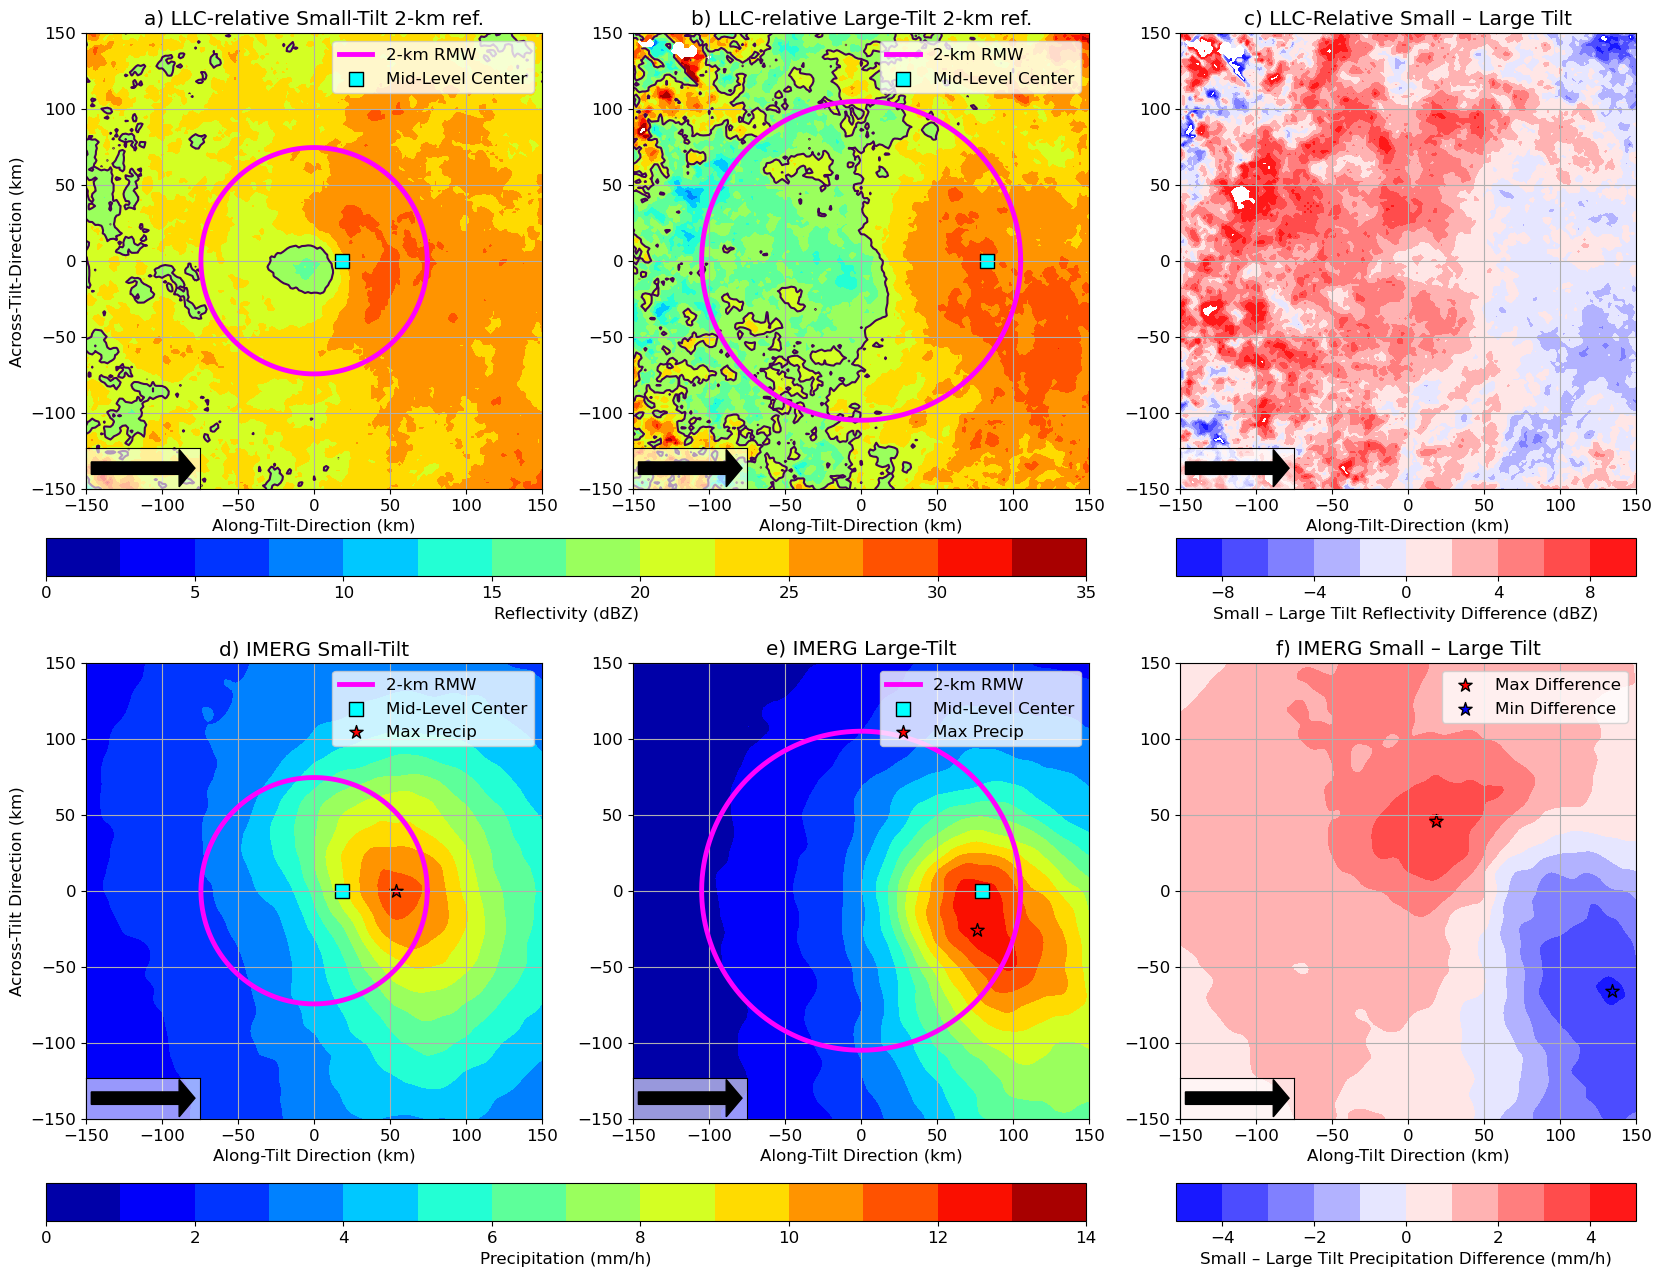

In [16]:
mean_small_tilt_rmw = filtered_tc_radar['tc_rmw'].sel(num_cases=small_tilt_indices,height=2).mean()
mean_large_tilt_rmw = filtered_tc_radar['tc_rmw'].sel(num_cases=large_tilt_indices,height=2).mean()
X1,Y1,THETA1 = circle([0,0],float(mean_small_tilt_rmw.mean().values),1000)
X2,Y2,THETA2 = circle([0,0],float(mean_large_tilt_rmw.mean().values),1000)

# Find mean MLCs

small_tilt_mlc_x = mlc_pd['MLC X (rotated)'][small_tilt_indices].mean()
small_tilt_mlc_y = mlc_pd['MLC Y (rotated)'][small_tilt_indices].mean()
large_tilt_mlc_x = mlc_pd['MLC X (rotated)'][large_tilt_indices].mean()
large_tilt_mlc_y = mlc_pd['MLC Y (rotated)'][large_tilt_indices].mean()

fig = plt.figure(figsize=(20, 15)) 

gs = fig.add_gridspec(2,3)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1)
ax3 = fig.add_subplot(gs[0, 2],adjustable='box', aspect=1)
cax_1 = plt.axes([0.105, 0.495, 0.52, 0.025])

mode = 'mean'
IMERG_mode = 'Precip'

if data_selection == 'recentered_reflectivity':
    if mode == 'std':
        p1 = ax.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                     rotated_images_xr.sel(num_cases=small_tilt_indices).std('num_cases'),cmap='jet',
                     levels=np.arange(0,15.1,2))
        plt.colorbar(p1,label='Reflectivity (dBZ)',cax=cax_1,orientation='horizontal')
        ax.set_title('a) LLC-relative Small-Tilt 2-km ref.')
    elif mode == 'mean':
        p1 = ax.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                     rotated_images_xr.sel(num_cases=small_tilt_indices).mean('num_cases'),cmap='jet',
                     levels=np.arange(0,35.1,2.5))
        plt.colorbar(p1,label='Reflectivity (dBZ)',cax=cax_1,orientation='horizontal')
        ax.set_title('a) LLC-relative Small-Tilt 2-km ref.')
        ax.contour(rotated_images_xr['x'],rotated_images_xr['y'],
                 rotated_images_xr.sel(num_cases=small_tilt_indices).mean('num_cases'),levels=[20])
else:
    p1 = ax.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                 rotated_images_xr.sel(num_cases=small_tilt_indices).std('num_cases'),cmap='jet',
                     levels=np.arange(0,32.1,4))
    plt.colorbar(p1,label='Velocity (m/s)')
    ax.set_title('a) LLC-relative Small-Tilt 2-km velo.')


# Plotting

# else:
#     ax.contour(rotated_images_xr['x'],rotated_images_xr['y'],
#                  rotated_images_xr.sel(num_cases=small_tilt_indices).mean('num_cases'))
ax.plot(X1,Y1,'magenta',lw=3.5,label = str(height)+'-km RMW')
ax.scatter(small_tilt_mlc_x,small_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',
               color='cyan',marker='s',label='Mid-Level Center')

ax.set_xlim(-150,150)
ax.set_ylim(-150,150)
ax.set_xlabel('Along-'+rotate_setting +' (km)')
ax.set_ylabel('Across-'+rotate_setting +' (km)')
ax.grid(True)
ax.legend(loc=1)
axins = inset_axes(ax, width="25%", height="9%", loc=3, borderpad=0)
axins.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins.patch.set_alpha(0.6)
# axins.set_title(rotate_setting, y=-1.21)
q = axins.arrow(0,0,0.05,0,color='black',head_length = 0.009)

if data_selection == 'recentered_reflectivity':
    if mode == 'std':
        p2 = ax2.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                     rotated_images_xr.sel(num_cases=large_tilt_indices).std('num_cases'),cmap='jet',
                     levels=np.arange(0,15.1,2))
        # plt.colorbar(p2,label='Reflectivity (dBZ)')
        ax2.set_title('b) LLC-relative Large-Tilt 2-km ref.')
    elif mode == 'mean':
        p2 = ax2.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                     rotated_images_xr.sel(num_cases=large_tilt_indices).mean('num_cases'),cmap='jet',
                     levels=np.arange(0,35.1,2.5))
        # plt.colorbar(p2,label='Reflectivity (dBZ)')
        ax2.set_title('b) LLC-relative Large-Tilt 2-km ref.')
        
        ax2.contour(rotated_images_xr['x'],rotated_images_xr['y'],
                 rotated_images_xr.sel(num_cases=large_tilt_indices).mean('num_cases'),levels=[20])
else:
    p2 = ax2.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
             rotated_images_xr.sel(num_cases=large_tilt_indices).std('num_cases'),cmap='jet',
                     levels=np.arange(0,32.1,4))
    plt.colorbar(p2,label='Velocity (m/s)')
    ax2.set_title('b) LLC-relative Large-Tilt 2-km velo.')


# Plotting

# else:
#     ax2.contour(rotated_images_xr['x'],rotated_images_xr['y'],
#                  rotated_images_xr.sel(num_cases=large_tilt_indices).mean('num_cases'))
ax2.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
ax2.scatter(large_tilt_mlc_x,large_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',
               color='cyan',marker='s',label='Mid-Level Center')
ax2.legend(loc=1)
ax2.set_xlabel('Along-'+rotate_setting +' (km)')
ax2.set_xlim(-150,150)
ax2.set_ylim(-150,150)
ax2.grid(True)
axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
# axins2.set_title(rotate_setting, y=-1.21)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)
cax_2 = plt.axes([0.67, 0.495, 0.23, 0.025])

# Plotting
if data_selection == 'recentered_reflectivity':
    if mode == 'std':
        p3 = ax3.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                     rotated_images_xr.sel(num_cases=small_tilt_indices).std('num_cases')-
                     rotated_images_xr.sel(num_cases=large_tilt_indices).std('num_cases'),cmap='bwr',
                     levels=np.arange(-7,7.1,2))
        plt.colorbar(p3,label='Reflectivity (dBZ)',cax=cax_2,orientation='horizontal')
    elif mode == 'mean':
        p3 = ax3.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                     rotated_images_xr.sel(num_cases=small_tilt_indices).mean('num_cases')-
                     rotated_images_xr.sel(num_cases=large_tilt_indices).mean('num_cases'),cmap='bwr',
                     levels=np.arange(-10,10.1,2))
        plt.colorbar(p3,label='Small – Large Tilt Reflectivity Difference (dBZ)',cax=cax_2,orientation='horizontal')      

else:
    p3 = ax3.contourf(rotated_images_xr['x'],rotated_images_xr['y'],
                 rotated_images_xr.sel(num_cases=small_tilt_indices).std('num_cases')-
                 rotated_images_xr.sel(num_cases=large_tilt_indices).std('num_cases'),cmap='bwr',
                     levels=np.arange(-10,10.1,1))
    plt.colorbar(p3,label='Velocity (m/s)')

    
ax3.set_xlim(-150,150)
ax3.set_ylim(-150,150)
ax3.set_xlabel('Along-'+rotate_setting +' (km)')
ax3.set_title('c) LLC-Relative Small – Large Tilt')
ax3.grid(True)
axins3 = inset_axes(ax3, width="25%", height="9%", loc=3, borderpad=0)
axins3.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins3.patch.set_alpha(0.6)
# axins3.set_title(rotate_setting, y=-1.21)
q3 = axins3.arrow(0,0,0.05,0,color='black',head_length = 0.009)


#------------------------------------------------------------------------

ax4 = fig.add_subplot(gs[1, 0],adjustable='box', aspect=1)
ax5 = fig.add_subplot(gs[1, 1],adjustable='box', aspect=1)
ax6 = fig.add_subplot(gs[1, 2],adjustable='box', aspect=1)
cax_4 = plt.axes([0.105, 0.065, 0.52, 0.025])

if IMERG_mode == 'dBZ':
    weak_cf4 = ax4.contourf(small_tilt_dBZ['x'], small_tilt_dBZ['y'],small_tilt_dBZ,np.arange(18,42.1,2))
#     weak_cf = ax.pcolormesh(x_evenly_last_sliced, y_evenly_last_sliced,small_tilt_dBZ)
    plt.colorbar(weak_cf,label='Reflectivity (dBZ)')
    ax4.grid()
    ax4.set_title('IMERG Small-Tilt')
    ax4.set_xlabel('Along-Tilt Direction (km)')
    ax4.set_ylabel('Across-Tilt Direction (km)')
    ax4.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax4.scatter(mean_small_tilt_mlc_x,mean_small_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',
               color='cyan',marker='s',label='Mid-Level Center')
    ind_1_max_small_dBZ_tilt = small_tilt_dBZ.argmax(dim=["x","y"])['x'].values
    ind_2_max_small_dBZ_tilt = small_tilt_dBZ.argmax(dim=["x","y"])['y'].values
    actual_x_small_dBZ_tilt = small_tilt_dBZ[ind_1_max_small_dBZ_tilt,ind_2_max_small_dBZ_tilt]['x']
    actual_y_small_dBZ_tilt = small_tilt_dBZ[ind_1_max_small_dBZ_tilt,ind_2_max_small_dBZ_tilt]['y']
    ax4.scatter(actual_x_small_dBZ_tilt,actual_y_small_dBZ_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max dBZ')
    ax4.legend(loc=1)
elif IMERG_mode == 'Precip':
    weak_cf4 = ax4.contourf(small_tilt_mean['x'], small_tilt_mean['y'],small_tilt_mean,levels=np.arange(0,14.1,1),cmap='jet')
    plt.colorbar(weak_cf4,label='Precipitation (mm/h)',orientation='horizontal',cax=cax_4)
    ax4.grid()
    ax4.set_title('d) IMERG Small-Tilt')
    ax4.set_xlabel('Along-Tilt Direction (km)')
    ax4.set_ylabel('Across-Tilt Direction (km)')
    ax4.plot(X,Y,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax4.scatter(mean_small_tilt_mlc_x,mean_small_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',
               color='cyan',marker='s',label='Mid-Level Center')
    ind_1_max_small_precip_tilt = small_tilt_mean.argmax(dim=["x","y"])['x'].values
    ind_2_max_small_precip_tilt = small_tilt_mean.argmax(dim=["x","y"])['y'].values
    actual_x_small_precip_tilt = small_tilt_mean[ind_1_max_small_precip_tilt,ind_2_max_small_precip_tilt]['x']
    actual_y_small_precip_tilt = small_tilt_mean[ind_1_max_small_precip_tilt,ind_2_max_small_precip_tilt]['y']
    ax4.scatter(actual_x_small_precip_tilt,actual_y_small_precip_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max Precip')    
    
    ax4.legend(loc=1)

axins4 = inset_axes(ax4, width="25%", height="9%", loc=3, borderpad=0)
axins4.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins4.patch.set_alpha(0.6)
q4 = axins4.arrow(0,0,0.05,0,color='black',head_length = 0.009)

if IMERG_mode == 'dBZ':
    cf5 = ax5.contourf(large_tilt_dBZ['x'], large_tilt_dBZ['y'],large_tilt_dBZ,levels=np.arange(18,42.1,2))
#     cf2 = ax2.pcolormesh(x_evenly_last_sliced, y_evenly_last_sliced,large_tilt_dBZ)
    # plt.colorbar(cf2,label='Reflectivity (dBZ)')
    ax5.set_title('IMERG Large-Tilt')
    ax5.set_xlabel('Along-Tilt Direction (km)')
    ax5.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax5.grid()
    ax5.scatter(mean_large_tilt_mlc_x,mean_large_tilt_mlc_y,s=100,linewidths = 1,edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
    ax5.legend()
    ind_1_max_large_dBZ_tilt = large_tilt_dBZ.argmax(dim=["x","y"])['x'].values
    ind_2_max_large_dBZ_tilt = large_tilt_dBZ.argmax(dim=["x","y"])['y'].values
    actual_x_large_dBZ_tilt = large_tilt_dBZ[ind_1_max_large_dBZ_tilt,ind_2_max_large_dBZ_tilt]['x']
    actual_y_large_dBZ_tilt = large_tilt_dBZ[ind_1_max_large_dBZ_tilt,ind_2_max_large_dBZ_tilt]['y']
    ax5.scatter(actual_x_large_dBZ_tilt,actual_y_large_dBZ_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max dBZ')
    ax5.legend(loc=1)

elif IMERG_mode == 'Precip':
    cf5 = ax5.contourf(large_tilt_mean['x'], large_tilt_mean['y'],large_tilt_mean,levels=np.arange(0,14.1,1),cmap='jet')
    # plt.colorbar(cf2,label='Precipitation (mm/h)')
    ax5.grid()
    ax5.set_title('e) IMERG Large-Tilt')
    ax5.set_xlabel('Along-Tilt Direction (km)')
    ax5.plot(X2,Y2,'magenta',lw=3.5,label = str(height)+'-km RMW')
    ax5.scatter(mean_large_tilt_mlc_x,mean_large_tilt_mlc_y,s=100,linewidths = 1,
                edgecolors = 'k',color='cyan',marker='s',label='Mid-Level Center')
    ind_1_max_large_precip_tilt = large_tilt_mean.argmax(dim=["x","y"])['x'].values
    ind_2_max_large_precip_tilt = large_tilt_mean.argmax(dim=["x","y"])['y'].values
    actual_x_large_precip_tilt = large_tilt_mean[ind_1_max_large_precip_tilt,ind_2_max_large_precip_tilt]['x']
    actual_y_large_precip_tilt = large_tilt_mean[ind_1_max_large_precip_tilt,ind_2_max_large_precip_tilt]['y']
    ax5.scatter(actual_x_large_precip_tilt,actual_y_large_precip_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max Precip')
    ax5.legend(loc=1)

axins5 = inset_axes(ax5, width="25%", height="9%", loc=3, borderpad=0)
axins5.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins5.patch.set_alpha(0.6)
q5 = axins5.arrow(0,0,0.05,0,color='black',head_length = 0.009)

if IMERG_mode == 'dBZ':
    ax_cf6 = ax6.contourf(large_tilt_dBZ['x'], large_tilt_dBZ['y'],small_tilt_dBZ-large_tilt_dBZ,cmap='bwr',
                         levels=np.arange(-9,9.1,1))
#     ax_cf = ax3.pcolormesh(x_evenly_last_sliced, y_evenly_last_sliced,small_tilt_dBZ-large_tilt_dBZ,cmap='bwr')
    plt.colorbar(ax_cf6,label='Small – Large Tilt Reflectivity Difference (dBZ)')
    ax6.set_title('IMERG Small – Large Tilt')
    ax6.set_xlabel('Along-Tilt Direction (km)')
    ind_1_max_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ).argmax(dim=["x","y"])['x'].values
    ind_2_max_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ).argmax(dim=["x","y"])['y'].values
    actual_x_max_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ)[ind_1_max_diff_dBZ_tilt,ind_2_max_diff_dBZ_tilt]['x']
    actual_y_max_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ)[ind_1_max_diff_dBZ_tilt,ind_2_max_diff_dBZ_tilt]['y']
    ax6.scatter(actual_x_max_diff_dBZ_tilt,actual_y_max_diff_dBZ_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Min Difference')

    ind_1_min_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ).argmin(dim=["x","y"])['x'].values
    ind_2_min_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ).argmin(dim=["x","y"])['y'].values
    actual_x_min_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ)[ind_1_min_diff_dBZ_tilt,ind_2_min_diff_dBZ_tilt]['x']
    actual_y_min_diff_dBZ_tilt = (small_tilt_dBZ-large_tilt_dBZ)[ind_1_min_diff_dBZ_tilt,ind_2_min_diff_dBZ_tilt]['y']
    ax6.scatter(actual_x_min_diff_dBZ_tilt,actual_y_min_diff_dBZ_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='blue',marker='*',label='Max Difference')

    ax6.legend(loc=1)
    ax6.grid()
elif IMERG_mode == 'Precip':
    ax_cf6 = ax6.contourf(large_tilt_mean['x'], large_tilt_mean['y'],small_tilt_mean-large_tilt_mean,cmap='bwr',
                         levels=np.arange(-5,5.1,1))
    cax_6 = plt.axes([0.67, 0.065, 0.23, 0.025])
    plt.colorbar(ax_cf6,label='Small – Large Tilt Precipitation Difference (mm/h)',orientation='horizontal',cax=cax_6)
    ax6.set_title('f) IMERG Small – Large Tilt')
    ax6.set_xlabel('Along-Tilt Direction (km)')
    ax6.grid()
    axins6 = inset_axes(ax6, width="25%", height="9%", loc=3, borderpad=0)
    axins6.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins6.patch.set_alpha(0.6)
    q6 = axins6.arrow(0,0,0.05,0,color='black',head_length = 0.009)
    
    ind_1_max_diff_precip_tilt = (small_tilt_mean-large_tilt_mean).argmax(dim=["x","y"])['x'].values
    ind_2_max_diff_precip_tilt = (small_tilt_mean-large_tilt_mean).argmax(dim=["x","y"])['y'].values
    actual_x_max_diff_precip_tilt = (small_tilt_mean-large_tilt_mean)[ind_1_max_diff_precip_tilt,ind_2_max_diff_precip_tilt]['x']
    actual_y_max_diff_precip_tilt = (small_tilt_mean-large_tilt_mean)[ind_1_max_diff_precip_tilt,ind_2_max_diff_precip_tilt]['y']
    ax6.scatter(actual_x_max_diff_precip_tilt,actual_y_max_diff_precip_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='red',marker='*',label='Max Difference')

    ind_1_min_diff_precip_tilt = (small_tilt_mean-large_tilt_mean).argmin(dim=["x","y"])['x'].values
    ind_2_min_diff_precip_tilt = (small_tilt_mean-large_tilt_mean).argmin(dim=["x","y"])['y'].values
    actual_x_min_diff_precip_tilt = (small_tilt_mean-large_tilt_mean)[ind_1_min_diff_precip_tilt,ind_2_min_diff_precip_tilt]['x']
    actual_y_min_diff_precip_tilt = (small_tilt_mean-large_tilt_mean)[ind_1_min_diff_precip_tilt,ind_2_min_diff_precip_tilt]['y']
    ax6.scatter(actual_x_min_diff_precip_tilt,actual_y_min_diff_precip_tilt,s=100,linewidths = 1,
                edgecolors = 'k',color='blue',marker='*',label='Min Difference')

    ax6.legend(loc=1)

plt.savefig('/Users/acheung/data/Figures/Paper_Figures/IMERG_vs_TDR.png',dpi=900)

# plt.figure()
# axhist = plt.axes()
# axhist.grid()
# axhist.set_axisbelow(True)

# axhist.hist(full_info_pd.loc[small_tilt_indices]['Tilt Magnitude'], histtype='bar',
#          bins=np.arange(0,180,10),label='Small Tilt',rwidth=1)
# axhist.hist(full_info_pd.loc[large_tilt_indices]['Tilt Magnitude'], histtype='bar',
#          bins=np.arange(0,180,10),label='Large Tilt',rwidth=1)
# axhist.hist(full_info_pd.loc[large_tilt_indices]['Tilt Magnitude'],
#          bins=np.arange(0,180,10),rwidth=1, fill=False)
# axhist.hist(full_info_pd.loc[small_tilt_indices]['Tilt Magnitude'],
#          bins=np.arange(0,180,10),rwidth=1, fill=False)

# axhist.set_xticks(np.arange(0,180,40))
# axhist.set_xlabel('Tilt Magnitude (km)')
# axhist.set_ylabel('Number of Cases')
# plt.legend()


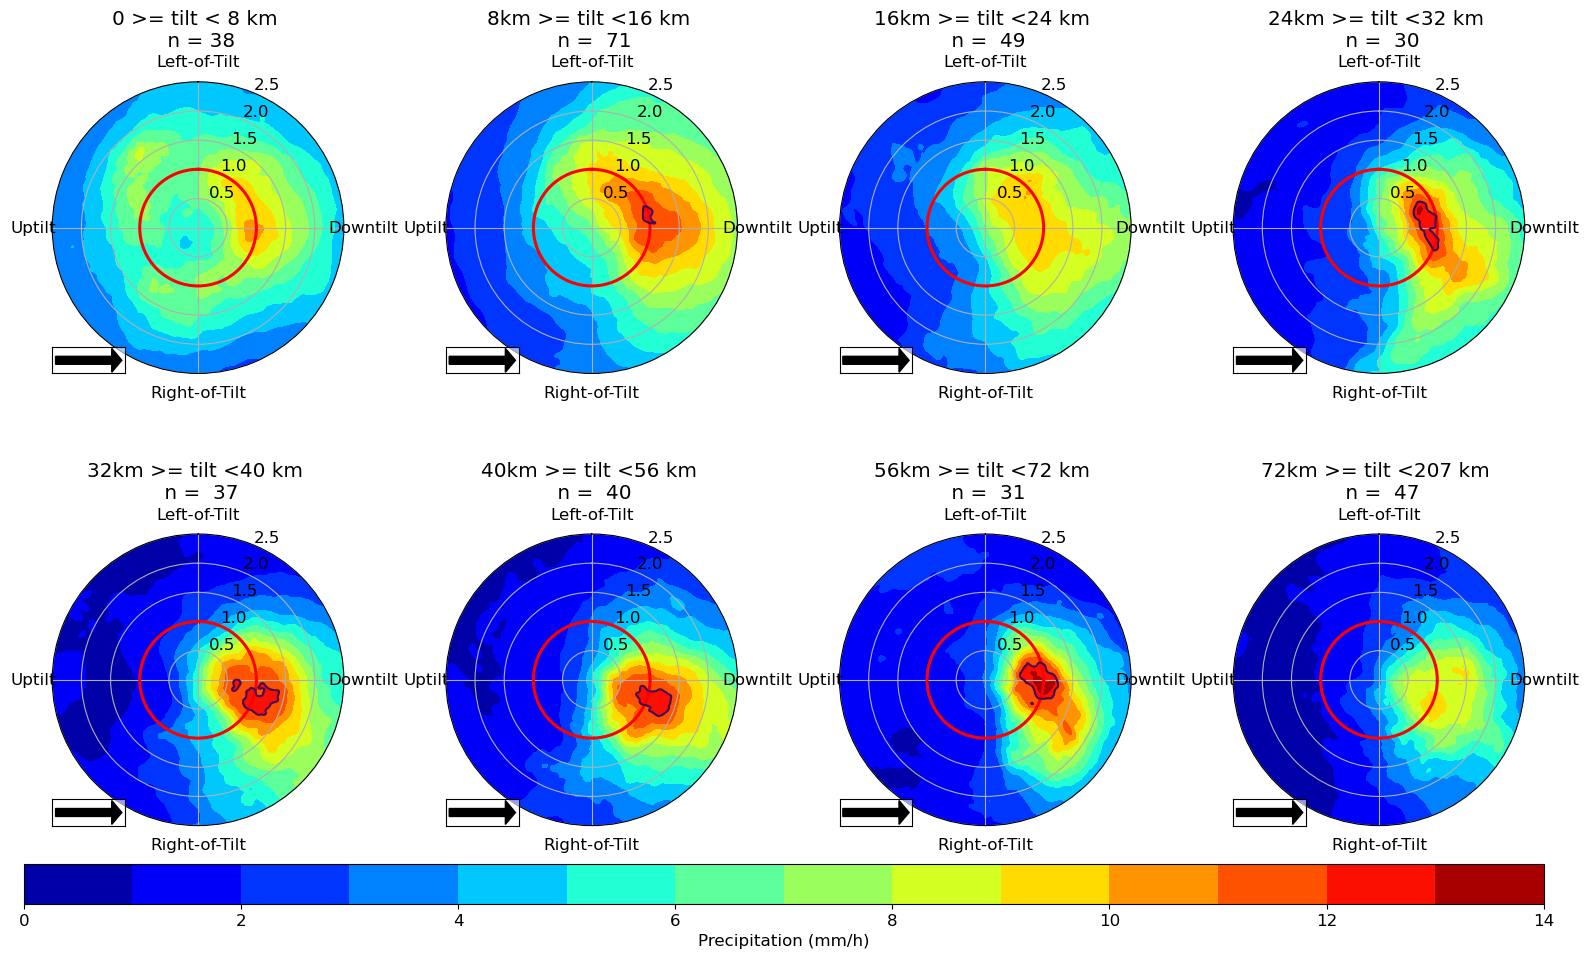

In [17]:
# Make subplots of strong TC precip field with varying tilt bins
fig, ax = plt.subplots(nrows=2, ncols=4,subplot_kw = dict(projection='polar'),figsize=(19,10))
ax_iteration = 0
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.35   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

for ax_i in ax.flatten():
    ax_i.grid(True)
#     ax_i.tick_params(axis='both', which='major', labelsize=7)
    if tilt_bin_setting == 'strong':
        cf_iter = ax_i.contourf(all_cylindrical_xr['azimuth'],
                    all_cylindrical_xr['radius'],
                                       all_cylindrical_xr.sel(case = bin_list[ax_iteration].index).mean('case'),
                               levels=np.arange(0,24.1,2),cmap='jet')        
    elif tilt_bin_setting == 'weak':
        cf_iter = ax_i.contourf(all_cylindrical_xr['azimuth'],
                    all_cylindrical_xr['radius'],
                                       all_cylindrical_xr.sel(case = bin_list[ax_iteration].index).mean('case'),
                               levels=np.arange(0,14.1,1),cmap='jet')
    cf_iter_2 = ax_i.contour(all_cylindrical_xr['azimuth'],
                all_cylindrical_xr['radius'],
                                   all_cylindrical_xr.sel(case = bin_list[ax_iteration].index).mean('case'),
                           levels=[12])
    
    n_cases = len(all_cylindrical_xr.sel(case = bin_list[ax_iteration].index))

    if ax_iteration == 0:
        ax_i.set_title('0 >= tilt < '+str(tilt_bin_edges[ax_iteration])+' km \n n = ' + str(n_cases))
    else:
        ax_i.set_title(str(tilt_bin_edges[ax_iteration-1]) + 'km >= tilt <' +
                       str(tilt_bin_edges[ax_iteration]) + ' km \n n =  ' + str(n_cases))
        
    ax_i_gl = ax_i.get_ygridlines()
    ax_i_b = ax_i_gl[1]
    ax_i_b.set_color('red')
    ax_i_b.set_linewidth(2.2)
    ax_i.set_theta_direction(-1)
    ax_i.set_theta_zero_location('N')
    ax_i.set_rlim(0,2.5)
    ax_i.set_xticks([0,np.pi/2,np.pi,1.5 * np.pi])
    ax_i.set_xticklabels(['Left-of-Tilt','Downtilt',
                     'Right-of-Tilt','Uptilt'])

    axins_i = inset_axes(ax_i, width="25%", height="9%", loc=3, borderpad=0)
    axins_i.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
    axins_i.patch.set_alpha(0.6)

    q_i = axins_i.arrow(0,0,0.05,0,color='black',head_length = 0.009)
        
    ax_iteration = ax_iteration + 1
cax = plt.axes([0.11, 0.05, 0.8, 0.04])
plt.colorbar(cf_iter,cax=cax,label='Precipitation (mm/h)',orientation='horizontal')

if tilt_bin_setting == 'weak':
    plt.savefig('/Users/acheung/data/Figures/Paper_Figures/IMERG_with_Tilt_RMW_Weak.png',dpi=900)
elif tilt_bin_setting == 'strong':
    plt.savefig('/Users/acheung/data/Figures/Paper_Figures/IMERG_with_Tilt_RMW_Strong.png',dpi=900)

(array([237., 274., 142.,  59.,  18.,  19.,  19.,  22.,  47., 103.]),
 array([3.62396240e-02, 3.60235880e+01, 7.20109364e+01, 1.07998285e+02,
        1.43985633e+02, 1.79972981e+02, 2.15960330e+02, 2.51947678e+02,
        2.87935027e+02, 3.23922375e+02, 3.59909723e+02]),
 <BarContainer object of 10 artists>)

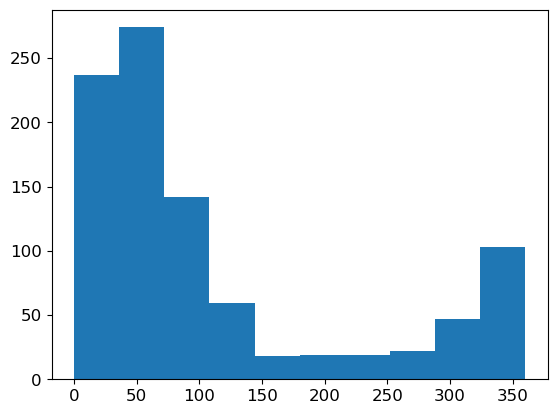

In [38]:
plt.hist(diff_pd,bins=)

/tmp/ipykernel_1217602/1703650799.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Downshear','Downshear-Left','Left of Shear',


Text(0.5, 1.0, 'Tilt-Direction vs. 2–6.5 km Tilt-Magnitude (km)')

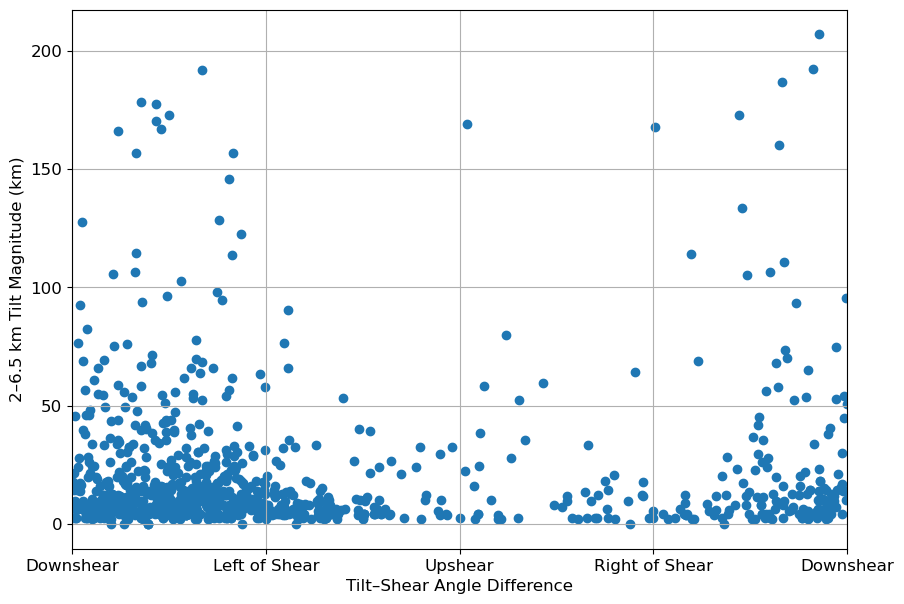

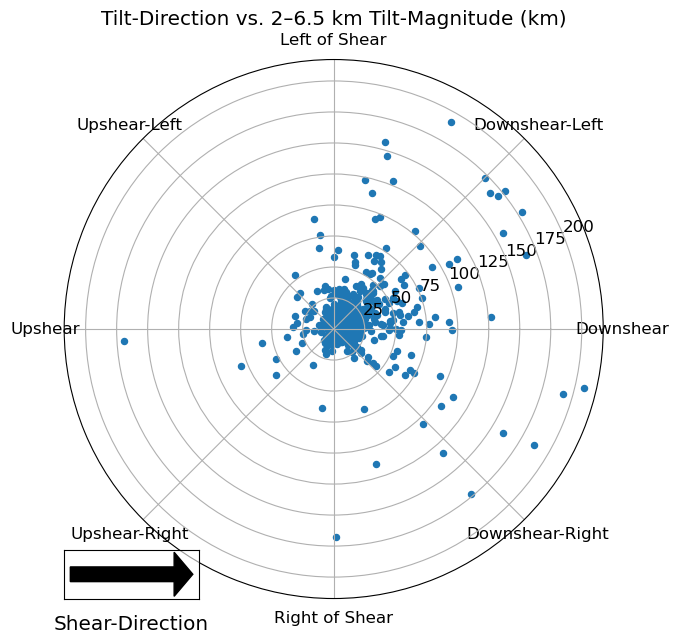

In [40]:
diff_pd = mlc_pd['Tilt-Angle']-mlc_pd['Shear-Angle']
diff_pd[diff_pd.where(diff_pd > 360).dropna().index] = diff_pd[
    diff_pd.where(diff_pd > 360).dropna().index] - 360
diff_pd[diff_pd.where(diff_pd < 0).dropna().index] = diff_pd[
    diff_pd.where(diff_pd < 0).dropna().index] + 360


plt.figure(figsize=(10,7))
ax=plt.axes()
ax.scatter(diff_pd,full_info_pd['Tilt Magnitude'])
# ax.hist(diff_pd)

# plt.plot(np.arange(-250,150),np.arange(-250,150),'--r')
ax.grid()
ax.set_ylabel('2–6.5 km Tilt Magnitude (km)')
ax.set_xlabel('Tilt–Shear Angle Difference')
ax.set_xlim(0,360)
ax.set_xticks(np.arange(0,360.1,90))
ax.set_xticklabels(['Downshear','Left of Shear','Upshear','Right of Shear','Downshear'])

plt.figure(figsize=(10,7))
ax2 = plt.axes(projection='polar')
ax2.scatter(diff_pd*(np.pi/180),full_info_pd['Tilt Magnitude'],s=19)
axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
axins2.set_title('Shear-Direction', y=-0.8)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)
ax2.set_xticklabels(['Downshear','Downshear-Left','Left of Shear',
                     'Upshear-Left','Upshear','Upshear-Right','Right of Shear',
                     'Downshear-Right','Downshear'])
ax2.set_title('Tilt-Direction vs. 2–6.5 km Tilt-Magnitude (km)')


[Text(0.0, 0, 'Downshear'),
 Text(90.0, 0, 'Left of Shear'),
 Text(180.0, 0, 'Upshear'),
 Text(270.0, 0, 'Right of Shear'),
 Text(360.0, 0, 'Downshear')]

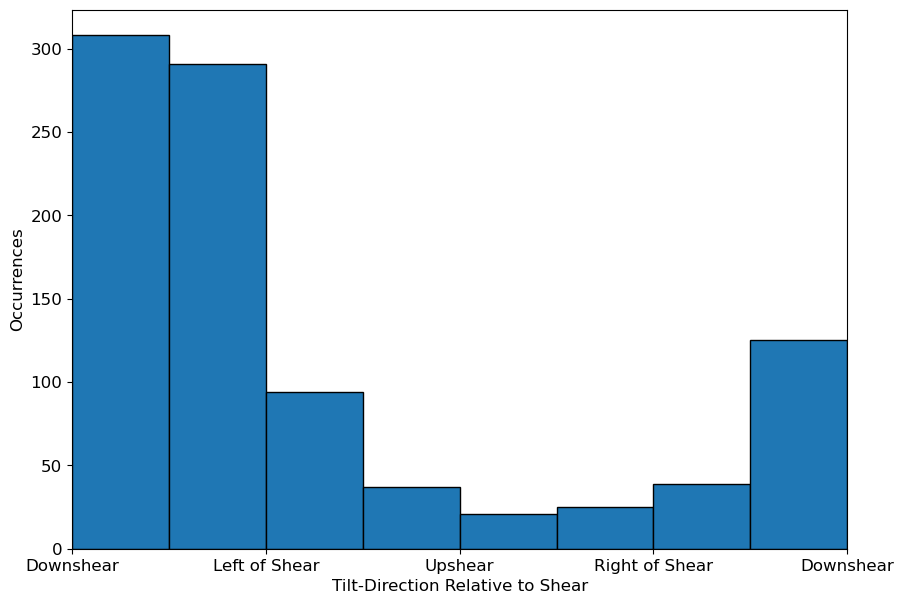

In [50]:
diff_pd = mlc_pd['Tilt-Angle']-mlc_pd['Shear-Angle']
diff_pd[diff_pd.where(diff_pd > 360).dropna().index] = diff_pd[
    diff_pd.where(diff_pd > 360).dropna().index] - 360
diff_pd[diff_pd.where(diff_pd < 0).dropna().index] = diff_pd[
    diff_pd.where(diff_pd < 0).dropna().index] + 360


plt.figure(figsize=(10,7))
ax=plt.axes()
ax.hist(diff_pd,bins=np.arange(0,360.1,45),edgecolor='black')
# ax.hist(diff_pd)

# plt.plot(np.arange(-250,150),np.arange(-250,150),'--r')
# ax.grid()
ax.set_ylabel('Occurrences')
ax.set_xlabel('Tilt-Direction Relative to Shear')
ax.set_xlim(0,360)
ax.set_xticks(np.arange(0,360.1,90))
ax.set_xticklabels(['Downshear','Left of Shear','Upshear','Right of Shear','Downshear'])


/tmp/ipykernel_1217602/2111177202.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(['Downshear','Downshear-Left','Left of Shear',


[Text(0.0, 0, 'Downshear'),
 Text(0.7853981633974483, 0, 'Downshear-Left'),
 Text(1.5707963267948966, 0, 'Left of Shear'),
 Text(2.356194490192345, 0, 'Upshear-Left'),
 Text(3.141592653589793, 0, 'Upshear'),
 Text(3.9269908169872414, 0, 'Upshear-Right'),
 Text(4.71238898038469, 0, 'Right of Shear'),
 Text(5.497787143782138, 0, 'Downshear-Right')]

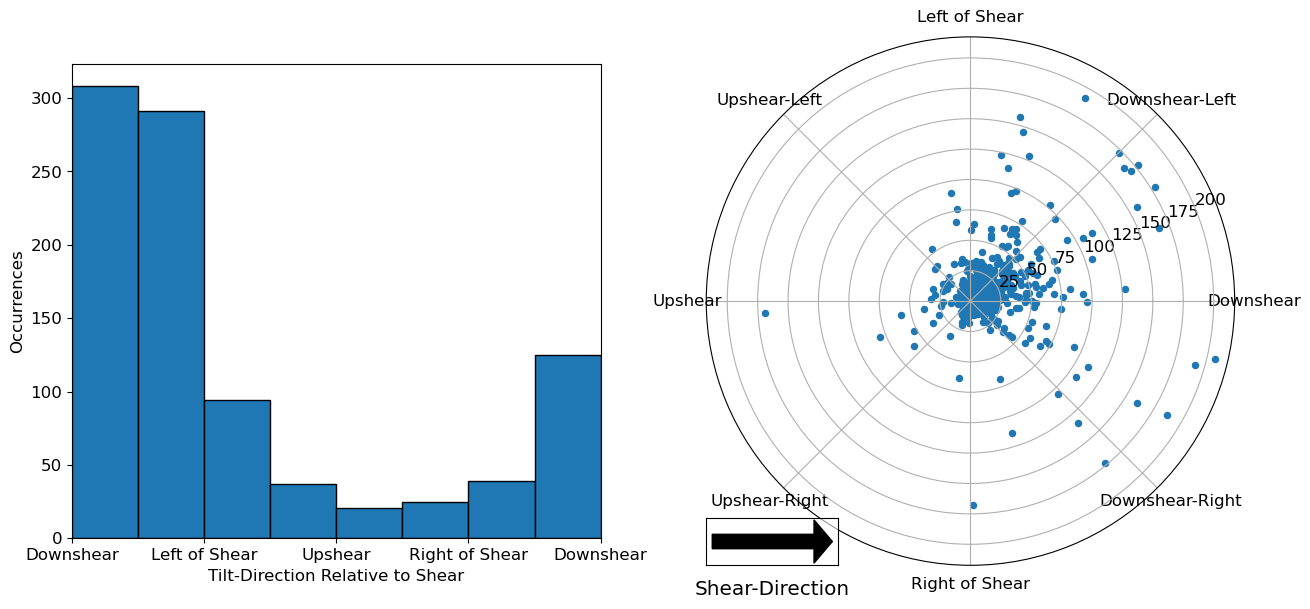

In [62]:
fig = plt.figure(figsize=(15,10)) 

gs = fig.add_gridspec(1,2)
ax = fig.add_subplot(gs[0, 0],adjustable='box', aspect=1)
ax2 = fig.add_subplot(gs[0, 1],adjustable='box', aspect=1,projection='polar')

diff_pd = mlc_pd['Tilt-Angle']-mlc_pd['Shear-Angle']
diff_pd[diff_pd.where(diff_pd > 360).dropna().index] = diff_pd[
    diff_pd.where(diff_pd > 360).dropna().index] - 360
diff_pd[diff_pd.where(diff_pd < 0).dropna().index] = diff_pd[
    diff_pd.where(diff_pd < 0).dropna().index] + 360

ax.hist(diff_pd,bins=np.arange(0,360.1,45),edgecolor='black')
# ax.hist(diff_pd)

# plt.plot(np.arange(-250,150),np.arange(-250,150),'--r')
# ax.grid()
ax.set_ylabel('Occurrences')
ax.set_xlabel('Tilt-Direction Relative to Shear')
ax.set_xlim(0,360)
ax.set_xticks(np.arange(0,360.1,90))
ax.set_xticklabels(['Downshear','Left of Shear','Upshear','Right of Shear','Downshear'])

ax2.scatter(diff_pd*(np.pi/180),full_info_pd['Tilt Magnitude'],s=19)
axins2 = inset_axes(ax2, width="25%", height="9%", loc=3, borderpad=0)
axins2.tick_params(labelleft=False, labelbottom=False,left = False,bottom = False)
axins2.patch.set_alpha(0.6)
axins2.set_title('Shear-Direction', y=-0.8)
q2 = axins2.arrow(0,0,0.05,0,color='black',head_length = 0.009)
ax2.set_xticklabels(['Downshear','Downshear-Left','Left of Shear',
                     'Upshear-Left','Upshear','Upshear-Right','Right of Shear',
                     'Downshear-Right','Downshear'])
# ax2.set_title('Tilt-Direction vs. 2–6.5 km Tilt-Magnitude (km)')


In [22]:
tilt_mag.sel(num_cases=mlc_pd['num_cases'].values)

<xarray.DataArray 'tc_tilt_magnitude' (num_cases: 940, height: 4)> Size: 15kB
dask.array<getitem, shape=(940, 4), dtype=float32, chunksize=(670, 4), chunktype=numpy.ndarray>
Coordinates:
  * num_cases  (num_cases) int64 8kB 0 1 2 3 4 5 ... 1335 1336 1337 1338 1339
  * height     (height) float32 16B 5.0 5.5 6.0 6.5
Attributes:
    units:      km
    long_name:  vortex tilt magnitude (relative to 2-km TC center)

In [20]:
diff_pd

num_cases
0       75.434952
1       57.000000
2       30.434952
3       38.565048
4       50.000000
          ...    
1335    50.194431
1336    63.434952
1337    60.255116
1338    71.565048
1339    63.434952
Length: 940, dtype: float64